# Analysis of the effect of ethnicity on food purchase in London's Tesco supermarkets

The objective of this project is to extend the Tesco dataset with a dataset containing numerous interesting socio-economic statistics in the London area. The analysis focuses on LSOA regions, which is the finest resolution available in the Tesco dataset. The proportion of inhabitants from various ethnicities is given for each LSOA in the additional dataset. We will first analyze the effect of ethnic diversity on food purchase. It will be based on the comparison of diversity of food categories purchased across LSOA regions and their ethnic diversity. We will then try to validate the observations we made by assessing if they still hold when other socio-economic aspects (such as mean wage for example) are taken into account. Depending on the results found, we will also investigate in greater details what impact specific ethnic populations may have on the food purchase.

## TO ADD marche à suivre (datasets, features, methods)

- Does ethnic diversity have an effect on food purchase at area level? And if yes, what is its nature?
- To which extent is the ethnic diversity responsible for the food purchase diversity?
- Can we attribute particular food purchase habits to specific ethnic groups?

## Table of contents

---

## 1. Set the environment and perform exploratory analysis

### Import the packages 

In [1]:
### Classic imports 

import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib

import os


### Imports for statistical analysis

import scipy
from scipy.stats import spearmanr

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split


### Imports for specific visualizations

import geopandas as gpd

import plotly
import plotly.express as px
import plotly.graph_objects as go


### Import associated to propensity score matching

from causal_curve import GPS


### Other imports

import re


---

## 2. Loading of the data

Three main datasets are used for this project:

In [2]:
GEO_LSOA_PATH = os.getcwd() + '/data/Geo_data/LSOA_2011_London_gen_MHW.shp'
TESCO_PATH = os.getcwd() + '/data/Area_level_data/year_lsoa_grocery.csv'
SOCIO_ECO_LSOA_PATH = os.getcwd() + '/data/lsoa-data.csv'

- **Tesco dataset**: besides the nutrients information used in the validation analysis of the paper, this dataset offers information on the purchases of different product categories at the area level. It's those information that will be used in our project at the LSOA level.

In [3]:
tesco_df = pd.read_csv(TESCO_PATH)
tesco_df.sample(5)

,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,weight_std,weight_ci95,volume,...,man_day,population,male,female,age_0_17,age_18_64,age_65+,avg_age,area_sq_km,people_per_sq_km
4595,E01004718,381.516411,32.5,157.7,300.0,490.0,1000.0,424.771945,4.928107,91.223680,...,7245,2173.0,1003.0,1170.0,500.0,1427.0,246.0,35.327197,0.07,29405.0
36,E01000039,351.716710,30.0,132.0,250.0,450.0,1000.0,464.177132,8.661504,105.875576,...,3264,1657.0,783.0,874.0,418.0,974.0,265.0,37.579964,1.53,1082.0
889,E01000908,337.678784,35.0,150.0,250.0,440.0,1000.0,319.495554,2.653828,102.730884,...,14960,1732.0,800.0,932.0,402.0,1059.0,271.0,39.207275,0.18,9897.0
4119,E01004223,404.468390,40.0,180.0,300.0,500.0,1200.0,441.432100,2.081786,110.624469,...,24268,2321.0,1110.0,1211.0,533.0,1519.0,269.0,35.670832,0.59,3918.0
2881,E01002948,288.899885,30.0,125.0,220.0,400.0,800.0,283.587092,7.684545,98.610033,...,2150,2217.0,1093.0,1124.0,605.0,1312.0,300.0,36.868742,5.26,421.0


- **Socio-economic dataset of the LSOA**: this dataset provides socio-economic information at the LSOA level. Combining this dataset with the Tesco one will allow us to put into perspective the ethnicity of the population with their food consumption. 

In [4]:
lsoa_df = pd.read_csv(SOCIO_ECO_LSOA_PATH, encoding = "ISO-8859-1", engine='python')
lsoa_df.sample(5)

,Lower Super Output Area,Names,Mid-year Population Estimates;All Ages;2001,Mid-year Population Estimates;All Ages;2002,Mid-year Population Estimates;All Ages;2003,Mid-year Population Estimates;All Ages;2004,Mid-year Population Estimates;All Ages;2005,Mid-year Population Estimates;All Ages;2006,Mid-year Population Estimates;All Ages;2007,Mid-year Population Estimates;All Ages;2008,...,Road Casualties;2012;Slight,Road Casualties;2012;2012 Total,Road Casualties;2013;Fatal,Road Casualties;2013;Serious,Road Casualties;2013;Slight,Road Casualties;2013;2013 Total,Road Casualties;2014;Fatal,Road Casualties;2014;Serious,Road Casualties;2014;Slight,Road Casualties;2014;2014 Total
1290,E01032637,Southwark 003F,920.0,961.0,1068.0,1169.0,1240.0,1242.0,1272.0,1307.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3680,E01002381,Havering 012F,1478.0,1430.0,1417.0,1404.0,1406.0,1484.0,1477.0,1466.0,...,3.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,2.0
895,E01003080,Lambeth 027B,1504.0,1479.0,1493.0,1476.0,1481.0,1464.0,1505.0,1568.0,...,0.0,1.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0
571,E01002748,Islington 006C,1499.0,1481.0,1520.0,1472.0,1471.0,1462.0,1486.0,1495.0,...,10.0,11.0,0.0,0.0,8.0,8.0,0.0,3.0,7.0,10.0
1833,E01033595,Westminster 013E,949.0,975.0,969.0,959.0,986.0,1026.0,1008.0,1060.0,...,99.0,110.0,1.0,13.0,129.0,143.0,0.0,7.0,92.0,99.0


- **Geographical information dataset of the LSOA**: this dataset will be used for visualization purposes as it will allow to display some of the results on the London map with relevant values assigned to each geographical region representing the LSOA. 

In [5]:
map_df = gpd.read_file(GEO_LSOA_PATH)
map_df.sample(5)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
2447,E01002499,Hillingdon 033D,E02006796,Hillingdon 033,E09000017,Hillingdon,E12000007,London,1705,1705,0,7.5,678,2.5,"POLYGON ((510692.161 185197.323, 510743.038 18..."
3515,E01003592,Newham 022B,E02000735,Newham 022,E09000025,Newham,E12000007,London,1842,1829,13,125.9,555,3.3,"POLYGON ((540650.318 183644.289, 540686.287 18..."
2732,E01002797,Islington 018B,E02000571,Islington 018,E09000019,Islington,E12000007,London,1873,1873,0,171.7,872,2.1,"POLYGON ((532347.320 184143.361, 532411.843 18..."
2416,E01002468,Hillingdon 010C,E02000503,Hillingdon 010,E09000017,Hillingdon,E12000007,London,1696,1696,0,86.1,633,2.7,"POLYGON ((510254.832 186952.897, 510276.491 18..."
2391,E01002443,Hillingdon 032A,E02000525,Hillingdon 032,E09000017,Hillingdon,E12000007,London,1625,1625,0,6.2,547,3.0,"POLYGON ((510218.125 177541.984, 510142.529 17..."


---

## 3. Cleaning and filtering of the data

### 3.1. Cleaning and filtering of the Tesco dataset

First we need to filter the tesco dataset to keep only what is interesting to our study:

Since we are mainly interested in the food purchase diversity, we decide to keep only the columns reporting the proportions of the different item categories as well as their normalized entropy. The nutritive values is indeed of no use for our analysis.
We also decide to keep the last columns of the dataset that report different demographic informations about the LSOAs.

In [6]:
def filter_and_clean_tesco(tesco_df):
    """
    filter the tesco dataset by removing columns not useful for our study
    """
    
    filtered_df = tesco_df.loc[:, 'area_id']
    filtered_df = pd.concat([ filtered_df, tesco_df.loc[:, 'f_beer':'f_wine'] ], axis=1)
    filtered_df = pd.concat([ filtered_df, tesco_df.loc[:, 'h_items_norm'] ], axis=1)
    filtered_df = pd.concat([ filtered_df, tesco_df.loc[:, 'representativeness_norm':] ], axis=1)

    return filtered_df

print("Size before filtering:", tesco_df.shape)
filt_tesco_df = filter_and_clean_tesco(tesco_df)
print("After filtering:", filt_tesco_df.shape)

Size before filtering: (4833, 202)
After filtering: (4833, 32)


### 3.2 Cleaning and filtering of the LSOA dataset

We then also need to filter and clean the LSOA dataset:

We decide to drop some columns that report information already present in the tesco dataset:
- Population estimates
- Population ages
- Population density

We drop the road casualities data as well as they are irrelevant to our question of interest.

This dataset is composed mainly of socio-economic data from 2011, some of the columns however have also values for other years in addition. We decide to keep only the data related to year 2011 to keep consistency.

Finally, many of the values reported in the dataset are reported both as an absolute number of people/household and as a percentage of the total population/number of household in a certain area. When this is the case, we decide to keep only the percentage values and to transform them into ratio comprised between 0 and 1 to keep consistency with the proportions reported in the tesco dataset that features this format.

In [7]:
def filter_and_clean_losa(lsoa_df):
    """
    Filter the LSOA dataset by removing columns not useful for our study
    """
    
    filtered_df = lsoa_df.copy()
    
    # drop the last 2 rows that are full of nan (due to the format of the title of the columns (3 rows))
    filtered_df.drop(lsoa_df.tail(2).index,inplace=True)
    
    ##### REPLACE UNKNOWN VALUES #####
    filtered_df.replace('-', np.NaN, inplace=True)
    filtered_df.replace('.', np.NaN, inplace=True)

    ##### DROP ALL IRRELEVANT COLUMNS #####
    # Mid-year Population Estimates (already in tesco data)
    # Census Population (already in tesco data)
    # Population Density (already in tesco data)
    # Road casualties (irrelevant)
    to_remove = ['Mid-year Population Estimates',
                 'Census Population',
                 'Population Density',
                 'BAME',
                 'Economically active: Total',
                 'Economically inactive: Total',
                 'Road Casualties']
    to_drop = []
    for col in filtered_df.columns:
        for sub in to_remove:
            if(sub in col):
                to_drop.append(col)
    filtered_df.drop(to_drop, axis=1, inplace=True)
    
    ##### DROP ALL COLUMNS NOT RELATED TO 2011 #####
    to_drop = []
    for col in filtered_df.columns:
        nums = re.findall('[0-9]+', col)
        for num in nums:
            if(len(num) == 4 and num != '2011'):
                to_drop.append(col)
    filtered_df.drop(to_drop, axis=1, inplace=True)
    
    ##### DROP ALL COLUMNS THAT ARE ABSOLUTE VALUE IF THERE IS PROPORTIONS FOR SAME DATA #####
    to_drop = []
    begin_with = ['Household Composition',
                  'Ethnic Group',
                  'Country of Birth',
                  'Household Language',
                  'Religion',
                  'Tenure',
                  'Dwelling type',
                  'Qualifications',
                  'Health',
                  'Car or van availability',
                  'Adults in Employment',
                  'Lone Parents']
    for col in filtered_df.columns:
        for sub in begin_with:
            if(col.startswith(sub) and '%' not in col):
                to_drop.append(col)
    filtered_df.drop(to_drop, axis=1, inplace=True)
    
    ##### TRANSFORM ALL PERCENTAGES VALUES IN RATIO BETWEEN 0 AND 1 #####
    for col in filtered_df.columns:
        if('%' in col):
            # convert to numerical value
            filtered_df[col] = pd.to_numeric(filtered_df[col])
            # transform percentage in ratio
            filtered_df[col] /= 100
            # rename the column
            new_name = col.replace("%", "ratio")
            filtered_df.rename(columns = {col: new_name}, inplace = True) 
            
        if('Rate' in col):
            # convert to numerical value
            filtered_df[col] = pd.to_numeric(filtered_df[col])
            # transform percentage in ratio
            filtered_df[col] /= 100
            # rename the column
            new_name = col.replace("Rate", "ratio")
            filtered_df.rename(columns = {col: new_name}, inplace = True)
    
    # remove spaces in column names
    filtered_df.columns = filtered_df.columns.str.replace(' ', '_')
    
    return filtered_df

print("Size before filtering:", lsoa_df.shape)
filt_lsoa_df = filter_and_clean_losa(lsoa_df)
print("After filtering:", filt_lsoa_df.shape)

Size before filtering: (4837, 277)
After filtering: (4835, 67)


### 3.3. Merging the different datasets

After the cleaning, we can now merge our different dataset of interest in a single one that we will use through the rest of our study.

In [8]:
def merge_data(tesco_df, lsoa_df, map_df):
    '''
    merge those datasets together to obtain as an output one single panda dataframe
    with the socio-economic, the Tesco and the geography information of each LSOA
    '''
    # set the index of this dataframe to the code of each LSOA to facilitate the merge of the dataframes
    map_df.index = map_df['LSOA11CD']
    
    # merge the Tesco dataframe with the one with the geo information of the corresponding regions  
    merged_map_df = map_df.join(tesco_df.set_index('area_id'))
    
    # convert coordinates that are in UTM format into latitude longitude (to plot the results on a map)
    merged_map_df = merged_map_df.to_crs({'init': 'epsg:4326'}) # cause of the warning
    
    # merge the merged dataframe with  the socio-economic dataframe of the corresponding regions  
    merged_map_lsoa_df = merged_map_df.join(lsoa_df.set_index('Lower_Super_Output_Area'))
    
    # set the index of this dataframe to the name of each LSOA to obtain more comprehensive data
    merged_map_lsoa_df.index = merged_map_lsoa_df['LSOA11NM']
    
    # remove the rows for which we don't have data everywhere 
    # consider the feature of population to determine where we lack some information
    population = np.array((merged_map_lsoa_df['population'])) 
    merged_map_lsoa_df = merged_map_lsoa_df[np.logical_not(np.isnan(population))]
    
    # return this final merged and cleaned dataset
    return merged_map_lsoa_df


full_df = merge_data(filt_tesco_df, filt_lsoa_df, map_df)
print('Shape after merging:', full_df.shape)
full_df.sample(5)

Shape after merging: (4833, 112)


,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,Health;Very_good_or_Good_health_(ratio);2011,Health;Fair_health_(ratio);2011,Health;Bad_or_Very_Bad_health_(ratio);2011,Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;1_car_or_van_in_household_(ratio);2011,Car_or_van_availability;2_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;3_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;4_or_more_cars_or_vans_in_household_(ratio);2011,"Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)","Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)"
LSOA11NM,,,,,,,,,,,,,,,,,,,,,
Wandsworth 036C,E01004519,Wandsworth 036C,E02000958,Wandsworth 036,E09000032,Wandsworth,E12000007,London,1767,1767,...,0.843,0.108,0.049,0.400,0.454,0.125,0.016,0.005,45873.0,33635.0
Richmond upon Thames 011B,E01003869,Richmond upon Thames 011B,E02000794,Richmond upon Thames 011,E09000027,Richmond upon Thames,E12000007,London,1617,1605,...,0.895,0.083,0.022,0.228,0.521,0.175,0.053,0.023,62719.0,48340.0
Enfield 018B,E01001477,Enfield 018B,E02000294,Enfield 018,E09000010,Enfield,E12000007,London,1850,1850,...,0.801,0.139,0.060,0.329,0.450,0.161,0.043,0.016,29242.0,23225.0
Greenwich 022D,E01001649,Greenwich 022D,E02000334,Greenwich 022,E09000011,Greenwich,E12000007,London,1530,1524,...,0.788,0.147,0.065,0.327,0.441,0.174,0.053,0.005,36871.0,28389.0
Croydon 010D,E01001111,Croydon 010D,E02000203,Croydon 010,E09000008,Croydon,E12000007,London,1607,1604,...,0.821,0.130,0.049,0.415,0.461,0.108,0.016,0.000,34507.0,27802.0


### 3.4 Note about representativity

The authors of the tesco dataset have created a representativity feature from the number of the different customers and the total population of the area to get a sense of how much Tesco groceries purchases could explain the overall dietary habits of the population in the area. It has to be done since this dataset do not report purchases made in other shops, nor the food consumed in restaurants for example.
Well aware of this limitation, we decide to focus our analysis on the purchases at Tesco themselves, more than trying to explain the variance in diets across the different ethnic groups. We hence decide not to filter the area by representativeness and to keep all the area in our analysis

---

## 4. Data wrangling

To get a sense of the diversity of certain features, such as the ethnic group proportions for example. We compute a normalized entropy for those distributions in the same fashion as presented in the tesco paper.

In [9]:
def compute_h_norm(df, f_col_list):
    
    f_df = df[f_col_list]
    n_col = len(f_col_list)
        
    h_df = pd.DataFrame()
    
    if np.any(f_df > 1):
        f_df = f_df.div(f_df.sum(axis=1), axis=0)
        
    # compute intermediates values inside the sum of eq (12)
    for col in f_df.columns:
        col_val = f_df[col] * np.log2(f_df[col])
        h_df.insert(len(h_df.columns), col, col_val, True)

    # compute the entropy as the sum of the intermediates values
    h = - h_df.sum(axis=1)
    h_df.insert(0, 'h', h, True)

    # remove all the intermediate values from the dataframe
    h_df = h_df.iloc[:, :1]

    # normalization
    h_df['h_norm'] = h_df['h'] / np.log2(n_col)
    
    return h_df['h_norm'].values

To add a bit of depth to the analysis, we decide to also compute 2 new entropies corresponding to food-only and drink-only items in addition to the items entropy already present in the tesco dataset.

In [10]:
food_col_list = ['f_dairy',
                 'f_eggs',
                 'f_fats_oils',
                 'f_fish',
                 'f_fruit_veg',
                 'f_grains',
                 'f_meat_red',
                 'f_poultry',
                 'f_readymade',
                 'f_sauces',
                 'f_sweets']

h_items_food_norm = compute_h_norm(full_df, food_col_list)

# insert new column
new_h_idx = full_df.columns.get_loc('h_items_norm') 
full_df.insert(new_h_idx, 'h_items_food_norm', h_items_food_norm.tolist(), True)

drink_col_list = ['f_beer',
                  'f_soft_drinks',
                  'f_spirits',
                  'f_tea_coffee',
                  'f_water',
                  'f_wine']

h_items_drink_norm = compute_h_norm(full_df, drink_col_list)

# insert two new column
new_h_idx = full_df.columns.get_loc('h_items_norm') 
full_df.insert(new_h_idx, 'h_items_drink_norm', h_items_drink_norm.tolist(), True)

We then compute an entropy of the diverse ethnic groups in each area to get a sense of the ethnic diversity of the area.

In [11]:
ethnicities_col_list = ['Ethnic_Group;White_(ratio);2011',
                        'Ethnic_Group;Mixed/multiple_ethnic_groups_(ratio);2011',
                        'Ethnic_Group;Asian/Asian_British_(ratio);2011',
                        'Ethnic_Group;Black/African/Caribbean/Black_British_(ratio);2011',
                        'Ethnic_Group;Other_ethnic_group_(ratio);2011']

h_ethnicities_norm = compute_h_norm(full_df, ethnicities_col_list)

# insert two new columns
new_h_idx = full_df.columns.get_loc('Country_of_Birth;ratio_United_Kingdom;2011') 
full_df.insert(new_h_idx, 'Ethnic_Group;h_ethnicities_norm;2011', h_ethnicities_norm.tolist(), True)

/home/maxime/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


We finally compute other entropies for different features represented in our dataset. This might prove itself useful later in our analysis.

In [12]:
household_compo_col_list = ['Household_Composition;ratio_Couple_household_with_dependent_children;2011',
                            'Household_Composition;ratio_Lone_parent_household;2011',
                            'Household_Composition;ratio_One_person_household;2011',
                            'Household_Composition;ratio_Other_multi_person_household;2011']

religion_col_list = ['Religion;Christian_(ratio);2011', 'Religion;Buddhist_(ratio);2011',
                     'Religion;Hindu_(ratio);2011', 'Religion;Jewish_(ratio);2011',
                     'Religion;Muslim_(ratio);2011', 'Religion;Sikh_(ratio);2011',
                     'Religion;Other_religion_(ratio);2011',
                     'Religion;No_religion_(ratio);2011',
                     'Religion;Religion_not_stated_(ratio);2011']

tenure_col_list = ['Tenure;Owned_outright_(ratio);2011',
                   'Tenure;Owned_with_a_mortgage_or_loan_(ratio);2011',
                   'Tenure;Social_rented_(ratio);2011',
                   'Tenure;Private_rented_(ratio);2011']

dwelling_col_list = ['Dwelling_type;Household_spaces_with_at_least_one_usual_resident_(ratio);2011',
                     'Dwelling_type;Household_spaces_with_no_usual_residents_(ratio);2011',
                     'Dwelling_type;Whole_house_or_bungalow:_Detached_(ratio);2011',
                     'Dwelling_type;Whole_house_or_bungalow:_Semi-detached_(ratio);2011',
                     'Dwelling_type;Whole_house_or_bungalow:_Terraced_(including_end-terrace)_(ratio);2011',
                     'Dwelling_type;Flat,_maisonette_or_apartment_(ratio);2011']

eco_activity_col_list = ['Economic_Activity;Economically_active:_Employee;2011',
                         'Economic_Activity;Economically_active:_Self-employed;2011',
                         'Economic_Activity;Economically_active:_Unemployed;2011',
                         'Economic_Activity;Economically_active:_Full-time_student;2011']

qualif_col_list = ['Qualifications;ratio_No_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_1_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_2_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Apprenticeship;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_3_qualifications;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Level_4_qualifications_and_above;2011',
                   'Qualifications;ratio_Highest_level_of_qualification:_Other_qualifications;2011',
                   'Qualifications;ratio_Schoolchildren_and_full-time_students:_Age_18_and_over;2011']

health_activ_col_list = ['Health;Day-to-day_activities_limited_a_lot_(ratio);2011',
                         'Health;Day-to-day_activities_limited_a_little_(ratio);2011',
                         'Health;Day-to-day_activities_not_limited_(ratio);2011']

health_state_col_list = ['Health;Very_good_or_Good_health_(ratio);2011',
                         'Health;Fair_health_(ratio);2011',
                         'Health;Bad_or_Very_Bad_health_(ratio);2011']

car_avail_col_list = ['Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011',
                      'Car_or_van_availability;1_car_or_van_in_household_(ratio);2011',
                      'Car_or_van_availability;2_cars_or_vans_in_household_(ratio);2011',
                      'Car_or_van_availability;3_cars_or_vans_in_household_(ratio);2011',
                      'Car_or_van_availability;4_or_more_cars_or_vans_in_household_(ratio);2011']

age_col_list = ['age_0_17', 'age_18_64', 'age_65+']


h_household_compo_norm = compute_h_norm(full_df, household_compo_col_list)
h_religion_norm = compute_h_norm(full_df, religion_col_list)
h_tenure_norm = compute_h_norm(full_df, tenure_col_list)
h_dwelling_norm = compute_h_norm(full_df, dwelling_col_list)
h_eco_activity_norm = compute_h_norm(full_df, eco_activity_col_list)
h_qualif_norm = compute_h_norm(full_df, qualif_col_list)
h_health_activ_norm = compute_h_norm(full_df, health_activ_col_list)
h_health_state_norm = compute_h_norm(full_df, health_state_col_list)
h_car_avail_norm = compute_h_norm(full_df, car_avail_col_list)
h_age_norm = compute_h_norm(full_df, age_col_list)


# insert the new columns
new_h_idx = full_df.columns.get_loc('Ethnic_Group;White_(ratio);2011') 
full_df.insert(new_h_idx, 'h_household_compo_norm', h_household_compo_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('Tenure;Owned_outright_(ratio);2011')
full_df.insert(new_h_idx, 'h_religion_norm', h_religion_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('Dwelling_type;Household_spaces_with_at_least_one_usual_resident_(ratio);2011')
full_df.insert(new_h_idx, 'h_tenure_norm', h_tenure_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('House_Prices;Median_Price_(£);2011')
full_df.insert(new_h_idx, 'h_dwelling_norm', h_dwelling_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('Qualifications;ratio_No_qualifications;2011')
full_df.insert(new_h_idx, 'h_eco_activity_norm', h_eco_activity_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('Health;Day-to-day_activities_limited_a_lot_(ratio);2011')
full_df.insert(new_h_idx, 'h_qualif_norm', h_qualif_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('Health;Very_good_or_Good_health_(ratio);2011')
full_df.insert(new_h_idx, 'h_health_activ_norm', h_health_activ_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011')
full_df.insert(new_h_idx, 'h_health_state_norm', h_health_state_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)')
full_df.insert(new_h_idx, 'h_car_avail_norm', h_car_avail_norm.tolist(), True)

new_h_idx = full_df.columns.get_loc('area_sq_km')
full_df.insert(new_h_idx, 'h_age_norm', h_age_norm.tolist(), True)


full_df.shape

/home/maxime/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/maxime/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/maxime/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/maxime/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/maxime/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


(4833, 125)

---

## 5. Exploration of the dataset

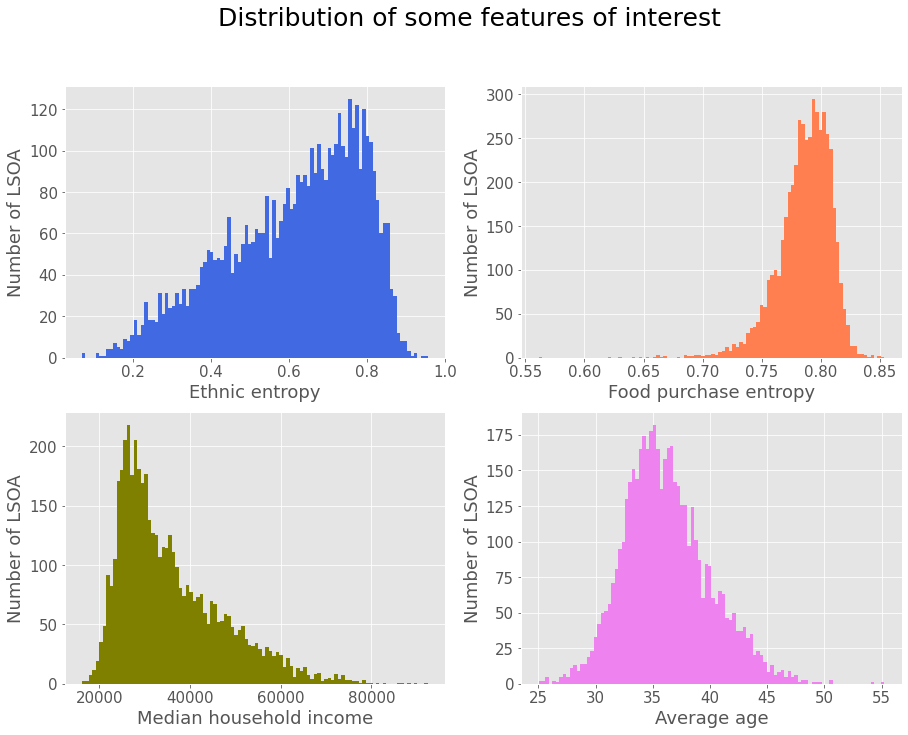

In [13]:
style.use('ggplot')

fig, ax = plt.subplots(2,2,figsize=(15,11))

plt.suptitle("Distribution of some features of interest", fontsize=25)

ax[0,0].hist(full_df['Ethnic_Group;h_ethnicities_norm;2011'], 100, color='royalblue')
ax[0,0].set_xlabel('Ethnic entropy', fontsize=18)
ax[0,0].set_ylabel('Number of LSOA', fontsize=18)
ax[0,0].tick_params(labelsize=15)

ax[0,1].hist(full_df['h_items_norm'], 100, color='coral')
ax[0,1].set_xlabel('Food purchase entropy', fontsize=18)
ax[0,1].set_ylabel('Number of LSOA', fontsize=18)
ax[0,1].tick_params(labelsize=15)

ax[1,0].hist(full_df['Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)'], 100, color='olive')
ax[1,0].set_xlabel('Median household income', fontsize=18)
ax[1,0].set_ylabel('Number of LSOA', fontsize=18)
ax[1,0].tick_params(labelsize=15)

ax[1,1].hist(full_df['avg_age'], 100, color='violet')
ax[1,1].set_xlabel('Average age', fontsize=18)
ax[1,1].set_ylabel('Number of LSOA', fontsize=18)
ax[1,1].tick_params(labelsize=15)

plt.show()

By looking at some of the main features in our dataset we see multiple interesting things. For example, the food purchase entropy does not seem like it varies a lot from an LSOA to another. As a lot of items are sold in Tesco, it is clear that the diversity in food purchase is high in general. In comparison, the median household income or the average age have a high variance from one LSOA to another, because the population can be completely different between areas. Think about an area in the center of London, compared to one in its suburbs. As housing prices are higher in the center, people that can afford such flats/houses tend to earn more money. Now if we come back to food purchase diversity: it is clear that, even if some people purchase a larger variation of items than other, these differences are small compared to the ones of other metrics. It is easy to find a Londoner earning 10x more money as another Londoner, but the same thing cannot be said for food purchase diversity. Therefore, food purchase diversity inherently has less variance than the other features presented here and it does not mean that differences in this feature cannot be meaningful.
Ethnic entropy has a lot of variance, with some areas very diverse in terms of ethnicities represented, while others are more conservative.

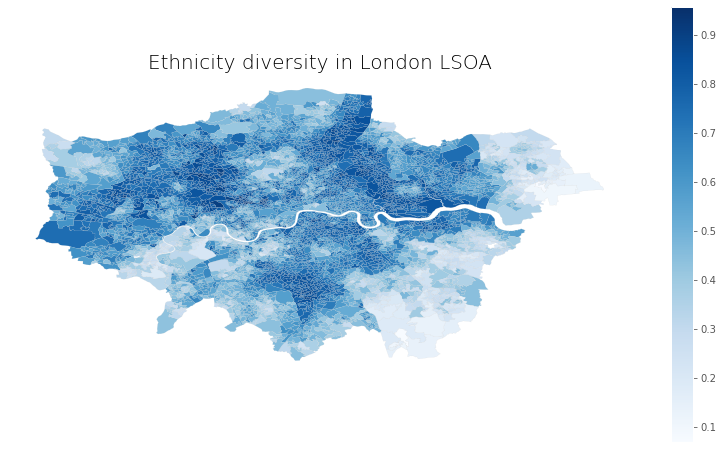

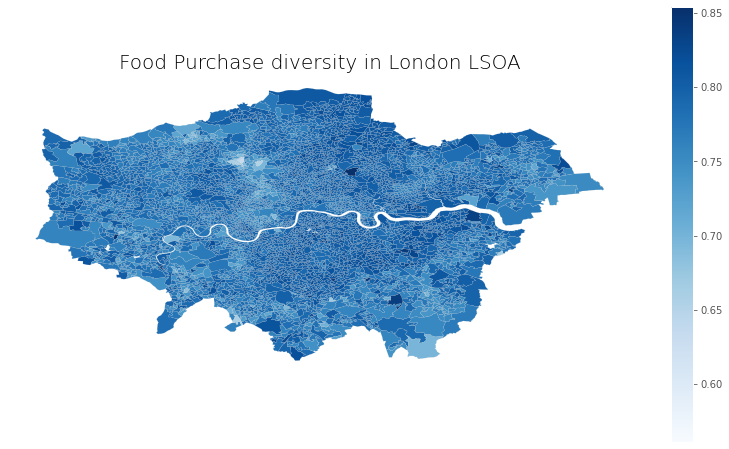

In [14]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Ethnic_Group;h_ethnicities_norm;2011'
# set the range for the choropleth
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(14, 8))
vmin = np.min(full_df[variable])
vmax = np.max(full_df[variable])

# create map
full_df.plot(column=variable, cmap='Blues', linewidth=0.1, ax=ax, edgecolor='0.8')
ax.axis('off')
# add a title
ax.set_title('Ethnicity diversity in London LSOA', fontdict={'fontsize': '20', 'fontweight' : '3'})

# Create colorbar as a legend
smap = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
smap._A = []
# add the colorbar to the figure
cbar = fig.colorbar(smap)

plt.show()


# set a variable that will call whatever column we want to visualise on the map
variable = 'h_items_norm'
# set the range for the choropleth
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(14, 8))
vmin = np.min(full_df[variable])
vmax = np.max(full_df[variable])

# create map
full_df.plot(column=variable, cmap='Blues', linewidth=0.1, ax=ax, edgecolor='0.8')
ax.axis('off')
# add a title
ax.set_title('Food Purchase diversity in London LSOA', fontdict={'fontsize': '20', 'fontweight' : '3'})

# Create colorbar as a legend
smap = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
smap._A = []
# add the colorbar to the figure
cbar = fig.colorbar(smap)

plt.show()

---

## 6. Correlation analysis

To begin our analysis, we want to see if there are significative relations between the ditstibutions of the different item categories and of the different ethnic groups represented in our dataset. We compute the Spearman rank correlation between those features at different level of granularity.

- Correlation between the normalized entropies of the items and the ethnicities
- Correlation between the different proportions of ethnic groups and the items entropies
- Correlation between the different propotrions of ethnic groups and different proportions of items category

To assess the significance of those correlations, we use a Bonferroni corrected significance value of $\frac{\alpha}{n}$ where $\alpha = 0.05$ and $n$ is the number of different correlation computed in each of our test.

### 6.1. Correlation between ethnic diversity and food and drink purchase diversity

In [15]:
h_ethnicity = full_df['Ethnic_Group;h_ethnicities_norm;2011'].values
h_items = full_df['h_items_norm'].values
h_items_food = full_df['h_items_food_norm'].values
h_items_drink = full_df['h_items_drink_norm'].values

rho_items, p_items = spearmanr(h_ethnicity, h_items)
rho_food, p_food = spearmanr(h_ethnicity, h_items_food)
rho_drink, p_drinks = spearmanr(h_ethnicity, h_items_drink)

d = {'Category': ['items','food', 'drink'],
     'R': [rho_items, rho_food, rho_drink],
     'p-value': [p_items, p_food, p_drinks]}
hh_corr_df = pd.DataFrame(data=d)
hh_corr_df

,Category,R,p-value
0,items,0.368818,1.285898e-155
1,food,0.286189,9.082810e-92
2,drink,0.192731,1.157947e-41


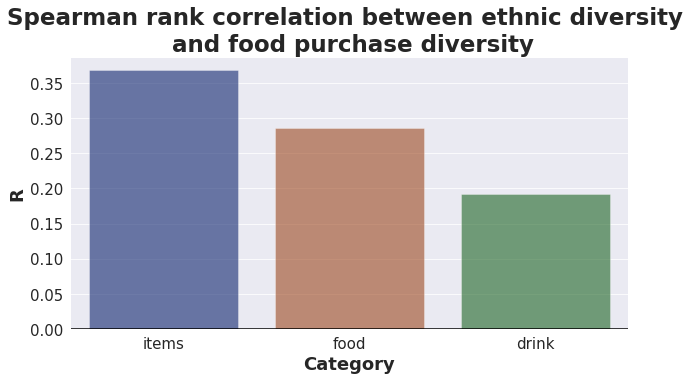

In [16]:
# keep only the significant data
n_test = 3
alpha_adj = 0.05/n_test # Bonferroni adjusted alpha
hh_plot_df = hh_corr_df[hh_corr_df['p-value'] < alpha_adj]

sns.set_style("dark")

plt.figure(figsize=(10,5))
ax = sns.barplot(x='Category', y='R', data=hh_plot_df, palette='dark', alpha=.6)
ax.grid(axis='y')
ax.set_ylabel('R', fontsize=18, fontweight='bold')
ax.set_xlabel('Category', fontsize=18, fontweight='bold')

#plt.xticks(rotation=90 )
ax.axhline(y=0, color='k', linestyle='-')
ax.set_title('Spearman rank correlation between ethnic diversity \n and food purchase diversity',
             fontsize=20, fontweight='bold')
ax.tick_params(labelsize=15)
plt.show()

Value of the Spearman rank correlation (R) between the normalized entropy of the different ethnic groups distributions and the normalized entropy of all items distributions (left), the normalized entropy of the food-only items distributions (middle) and the normalized entropy of the drink-only items distribution (right). Only significative correlations with $p-value < \frac{0.05}{3}$ are reported. 

As we can see on this figure, there is a positive correlation between the ethnic diversity in an area and the diversity of items in the shopping carts. We can also see that the ethnic diversity is more correlated with food items diversity than with drinks.

From this first analysis, we could hypothesise that having more ethnic diversity in an area leads to a multiplicity of different diets influenced by cultural factors. Since product categories can have a different prevalence accross various dietary habits, having more of those various diets would tend to even the proportions of the different categories, hence to increase the item entropy.
We could also hypothesise that the cultural aspects of different diets is more dicted by what the people eat than what they drink.

### 6.2. Correlation between the different proportions of ethnic groups and h_food_norm, h_drink_norm

In [17]:
f_ethnicity_idx_lo = full_df.columns.get_loc('Ethnic_Group;White_(ratio);2011')
f_ethnicity_idx_hi = full_df.columns.get_loc('Ethnic_Group;Other_ethnic_group_(ratio);2011')+1

# list containing the name of the ethnic groups
ethnicity_col = np.array(full_df.columns[f_ethnicity_idx_lo:f_ethnicity_idx_hi]) 
ethnic_col_short = np.array(['White', 'Mixed', 'Asian', 'Black', 'Other ethnicities'])

n_ethnicity = ethnicity_col.shape[0]

# list containing the name of the item categories (food or drink)
category_col = np.array(['items',
                         'food',
                         'drink'])
n_category = category_col.shape[0]

# repeat elements to have same length and suitable format
ethnicity_col = np.repeat(ethnicity_col, n_category)
ethnic_col_short = np.repeat(ethnic_col_short, n_category)
category_col = np.tile(category_col, n_ethnicity)

# list containing the values of the ethnic group representations
f_ethnicities = []
for col in full_df.iloc[:, f_ethnicity_idx_lo:f_ethnicity_idx_hi].columns:
    f_ethnicities.append(full_df[col].values)

# list containing the values of items entropy for food and drink
h_items = full_df['h_items_norm'].values
h_items_food = full_df['h_items_food_norm'].values
h_items_drink = full_df['h_items_drink_norm'].values
h_item_categories = [h_items, h_items_food, h_items_drink]

# compute the correlation and their p-values
R_col = []
p_col = []
for et in f_ethnicities:
    for cat in h_item_categories:
        R, p = spearmanr(et, cat)
        R_col.append(R)
        p_col.append(p)

d = {'Ethnicity': ethnic_col_short.tolist(),
     'Category': category_col.tolist(),
     'R': R_col,
     'p-value': p_col}

fh_corr_df = pd.DataFrame(data = d)
fh_corr_df

,Ethnicity,Category,R,p-value
0,White,items,-0.236992,1.109595e-62
1,White,food,-0.148771,2.537757e-25
2,White,drink,-0.155952,1.082312e-27
3,Mixed,items,0.441581,7.456270e-230
4,Mixed,food,0.310607,1.375516e-108
5,Mixed,drink,0.249160,2.676778e-69
6,Asian,items,-0.114748,1.227568e-15
7,Asian,food,-0.053519,1.974140e-04
8,Asian,drink,-0.078691,4.310637e-08
9,Black,items,0.572196,0.000000e+00


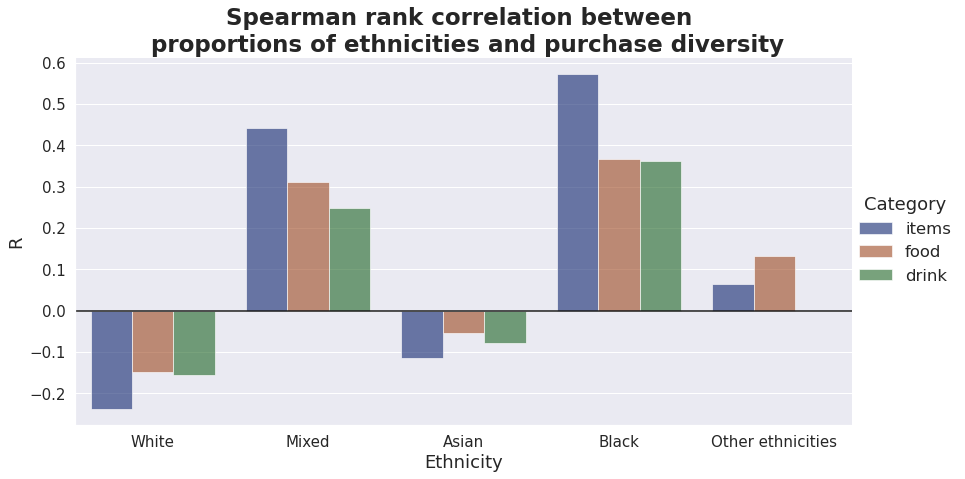

In [18]:
# keep only the significant data 
n_test = 15
alpha_adj = 0.05/n_test # Bonferroni adjusted alpha
fh_plot_df = fh_corr_df[fh_corr_df['p-value'] < alpha_adj]

sns.set_style("dark")
sns.set(font_scale=1.5)

g = sns.catplot(data=fh_plot_df, kind="bar", x="Ethnicity", y="R", hue="Category", palette="dark", 
                alpha=.6, height=6, aspect=2)

for ax in g.axes.flat:
    ax.grid(True, axis='y')
ax.axhline(y=0, color='k')

#plt.xticks(rotation=45 )

ax.tick_params(labelsize=15)

ax.set_title('Spearman rank correlation between \n proportions of ethnicities and purchase diversity',
             fontsize=23, fontweight='bold')

plt.show()

Value of the Spearman rank correlation (R) between the proportions of the different ethnic groups and the normalized entropy of all items distributions, food-only items distribution and drink-only items distributions. Only significative correlations with $p-value < \frac{0.05}{15}$ are reported. 

From this figure, we can see that the proportions of the different ethnic groups correlates diferently with the item diversity. Mixed and Black ethnic groups show positive correlation with the black ethnic group being the one with the larger positive correlation with item diversity. White and Asian ethnic groups show negative correlation, white ethnic group being the one with the more negative correlation value. The other ethnicities have a lower positive correlation value and is the only group to display a non significative correlation value (drinks).

Here again we can elaborate hypothesis to explain those results. Since the level of representativity we chose can not assess for the overall dietary habit of the different ethnic groups, those correlation can not assess if the overall diet of the a different ethnic group is more or less diverse than another or if different ethnic groups just do some of their groceries at Tesco, and get the rest of their food elsewhere. 
At this point, we could hypothesise that the groups with higher positive correlation values tend to get most or all of their food at Tesco, while the ones with negatives correlation values might get some products there and turn to other sources for other items.

### 6.3. Correlation between the different proportions of ethnic groups and different proportions of items category

In [19]:
# list containing names of the different products proportions
f_items_idx_lo = full_df.columns.get_loc('f_beer') 
f_items_idx_hi = full_df.columns.get_loc('f_wine')+1
item_col = np.array(full_df.columns[f_items_idx_lo:f_items_idx_hi]) # list containing name of the columns
n_item = item_col.shape[0]

# list containing names of the different ethnic groups
f_ethnicity_idx_lo = full_df.columns.get_loc('Ethnic_Group;White_(ratio);2011')
f_ethnicity_idx_hi = full_df.columns.get_loc('Ethnic_Group;Other_ethnic_group_(ratio);2011')+1
ethnicity_col = np.array(full_df.columns[f_ethnicity_idx_lo:f_ethnicity_idx_hi]) # list containing name of the columns
ethnicity_col_short = np.array(['White', 'Mixed', 'Asian', 'Black', 'Other ethnicities'])
n_ethnicity = ethnicity_col.shape[0]

# repeat elements to get good format
item_col = np.tile(item_col, n_ethnicity)
ethnicity_col = np.repeat(ethnicity_col, n_item)
ethnicity_col_short = np.repeat(ethnicity_col_short, n_item)


f_items = []
for col in full_df.iloc[:, f_items_idx_lo:f_items_idx_hi].columns:
    f_items.append(full_df[col].values)

f_ethnicities = []
for col in full_df.iloc[:, f_ethnicity_idx_lo:f_ethnicity_idx_hi].columns:
    f_ethnicities.append(full_df[col].values)
    
R_col = []
p_col = []

for et in f_ethnicities:
    for item in f_items:
        R, p = spearmanr(et, item)
        R_col.append(R)
        p_col.append(p)

d = {'Ethnicity': ethnicity_col.tolist(),
     'Item': item_col.tolist(),
     'R': R_col,
     'p-value': p_col}
      
ff_corr_df = pd.DataFrame(data = d)

# add a "Category column" to label items as food or drink
def is_food_or_drink(Item):
    
    food_list = set(['f_dairy',
                     'f_eggs',
                     'f_fats_oils',
                     'f_fish',
                     'f_fruit_veg',
                     'f_grains',
                     'f_meat_red',
                     'f_poultry',
                     'f_readymade',
                     'f_sauces',
                     'f_sweets'])

    drink_list = set(['f_beer',
                      'f_soft_drinks',
                      'f_spirits',
                      'f_tea_coffee',
                      'f_water',
                      'f_wine'])
    
    if Item in food_list :
        return "food"
    elif Item in drink_list :
        return "drink"

ff_corr_df.insert(1, 'Category', ff_corr_df['Item'].apply(is_food_or_drink), True)
ff_corr_df

,Ethnicity,Category,Item,R,p-value
0,Ethnic_Group;White_(ratio);2011,drink,f_beer,0.205189,4.187796e-47
1,Ethnic_Group;White_(ratio);2011,food,f_dairy,-0.273152,1.895280e-83
2,Ethnic_Group;White_(ratio);2011,food,f_eggs,-0.309786,5.383464e-108
3,Ethnic_Group;White_(ratio);2011,food,f_fats_oils,-0.426744,3.490461e-213
4,Ethnic_Group;White_(ratio);2011,food,f_fish,-0.013208,3.586075e-01
...,...,...,...,...,...
80,Ethnic_Group;Other_ethnic_group_(ratio);2011,drink,f_spirits,0.098075,8.323222e-12
81,Ethnic_Group;Other_ethnic_group_(ratio);2011,food,f_sweets,-0.239118,8.226865e-64
82,Ethnic_Group;Other_ethnic_group_(ratio);2011,drink,f_tea_coffee,0.110457,1.354980e-14
83,Ethnic_Group;Other_ethnic_group_(ratio);2011,drink,f_water,0.189520,2.553798e-40


We decided to display those correlation results into two different heatmaps (one for the food categories and one for the drink categories) for readability purposes.

<ipython-input-20-48a9cb06bb11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['R'][plot_df['p-value'] >= alpha_adj] = np.nan


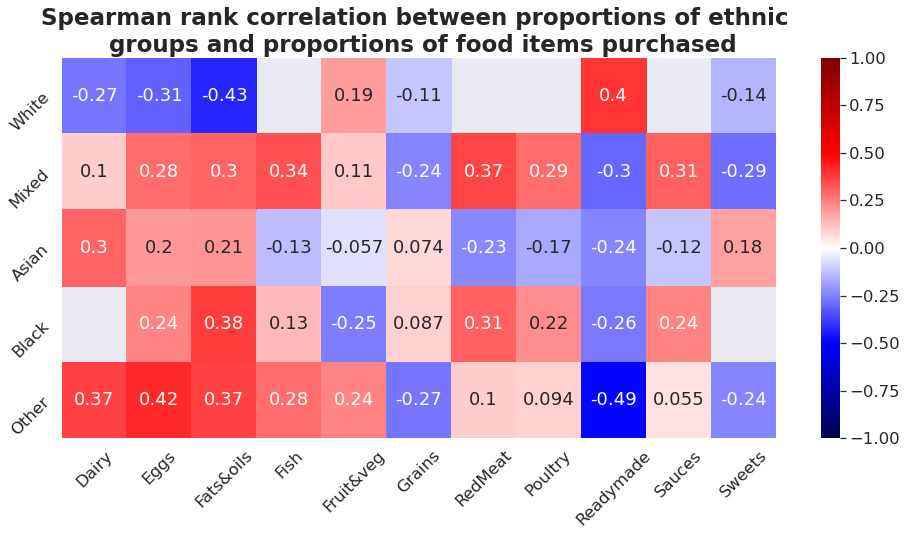

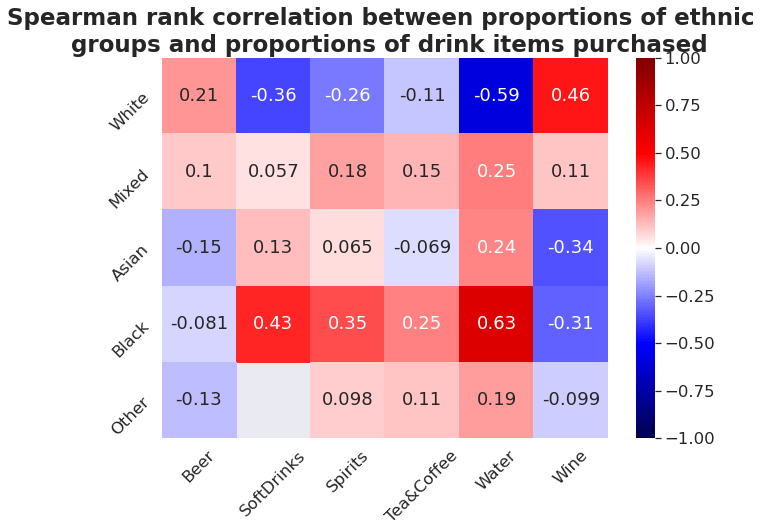

In [20]:
# keep only the significant data
n_test = 85
alpha_adj = 0.05/n_test # Bonferroni adjusted alpha
plot_df = ff_corr_df.copy()
plot_df['R'][plot_df['p-value'] >= alpha_adj] = np.nan
plot_df

ethnicity_list = np.array(full_df.columns[f_ethnicity_idx_lo:f_ethnicity_idx_hi]).tolist()
n_ethnicity = len(ethnicity_list)
n_food = 11
n_drink = 6

R_food_np = np.zeros((n_ethnicity, n_food))
R_drink_np = np.zeros((n_ethnicity, n_drink))

for i in range(n_ethnicity):
    R_food_np[i,:] = plot_df['R'][np.logical_and(plot_df['Ethnicity'] == ethnicity_list[i], plot_df['Category'] == 'food')]
    R_drink_np[i,:] = plot_df['R'][np.logical_and(plot_df['Ethnicity'] == ethnicity_list[i], plot_df['Category'] == 'drink')]


ethnicities_list = ['White',
                    'Mixed',
                    'Asian',
                    'Black',
                    'Other']    
    
food_list = ['Dairy',
             'Eggs',
             'Fats&oils',
             'Fish',
             'Fruit&veg',
             'Grains',
             'RedMeat',
             'Poultry',
             'Readymade',
             'Sauces',
             'Sweets']

drink_list = ['Beer',
              'SoftDrinks',
              'Spirits',
              'Tea&Coffee',
              'Water',
              'Wine']


plt.figure(figsize=(16,7))
ax = sns.heatmap(R_food_np, annot=True, vmin=-1, vmax=1, cmap='seismic')
ax.set_title('Spearman rank correlation between proportions of ethnic \n groups and proportions of food items purchased', 
             fontsize=23, fontweight='bold')

ax.set_xticklabels(food_list)
plt.xticks(rotation=45)
ax.set_yticklabels(ethnicities_list)
plt.yticks(rotation=45)

plt.figure(figsize=(10,7))
ax = sns.heatmap(R_drink_np, annot=True, vmin=-1, vmax=1, cmap='seismic')
ax.set_title('Spearman rank correlation between proportions of ethnic \n groups and proportions of drink items purchased', 
             fontsize=23, fontweight='bold')

ax.set_xticklabels(drink_list)
plt.xticks(rotation=45)
ax.set_yticklabels(ethnicities_list)
plt.yticks(rotation=45)
plt.show()

Figures above show the correlation between the proportion of the different ethnic groups and the proportion of the different food and drink items in a heatmap. Positively and negatively correlated proportions are showed respectively in red and blue. Only significative correlations with $p-value < \frac{0.05}{85}$ are reported, non-significative correlations are represented as gray cells with no correlation values. 

With this level of granularity, we can see that the proportions of the different ethnic groups are actually correlated differently to the proportions of the food items.
Those results can help to explain the correlation found in the previous figure.
Wee indeed see that ethnic groups that showed a more positive correlation with item diversity (Mixed, Black and Other) tends to have a majority of positively correlated proportion of items.
For the two groups that showed negative correlation with item diversity (White and Asian), we can see that they present a majority of negatively correlated features. 

## TO ADD CONCLUSION (2-3 examples of interpretation + reminder of the limitations (Tesco or regime alimentaire ?) --> LINK WITH CAUSALITY ANALYSIS

---

## 7. Causality analysis

# NEW ERIC

We have seen that there exist correlations between food purchase diversity and ethnic diversity in LSOA, as well as between the proportions of some ethnicities and categories of items purchased. These are already encouraging results. However, the correlation between two features does not give any information about the causal link between them. For example, in some cases two features can be highly correlated, but because of the presence of one or more confounders, no causal link can be established. To dig deeper in the analysis of the effect of ethnic diversity on food purchase diversity, we will perform multiple tests aiming at demonstrating a causal effect of ethnic diversity on food purchase diversity.

We will start by a naive analysis using linear regressions to weight the impact of ethnic diversity and potential confounders on food purchase diversity. We will then use the notion of propensity score matching to be able to finally answer the main questions of this work.  

### 7.1. Naive initial analysis using Linear Regression

# NEW ERIC

To get an idea of the effect of multiple features on food purchase diversity, we first performed a linear regression analysis. 

From our intuition, we selected features that we initially thought impacted food purchase diversity the most. We standardized them to be able to interpret better the weight of each feature selected on the output feature (`h_items_norm`).

In [21]:
employment_rate = full_df['Economic_Activity;Employment_ratio;2011']
employment_rate_stand = (employment_rate - np.mean(employment_rate))/np.std(employment_rate)

median_household_income = full_df['Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)']
median_household_income_stand = (median_household_income - np.mean(median_household_income))/np.std(median_household_income)

avg_age = full_df['avg_age']
avg_age_stand = (avg_age - np.mean(avg_age))/np.std(avg_age)

h_items = full_df['h_items_norm']
h_items_stand = (h_items - np.mean(h_items))/np.std(h_items)

h_ethnicity = full_df['Ethnic_Group;h_ethnicities_norm;2011']
h_ethnicity_stand = (h_ethnicity - np.mean(h_ethnicity))/np.std(h_ethnicity)

We then build a dataframe containing the data that will be used in this part of the analysis.

In [22]:
lin_reg_df = pd.DataFrame()
lin_reg_df['employment_rate'] = employment_rate_stand
lin_reg_df['median_household_income'] = median_household_income_stand
lin_reg_df['avg_age'] = avg_age_stand
lin_reg_df['h_items'] = h_items_stand
lin_reg_df['h_ethnicity'] = h_ethnicity_stand
lin_reg_df.head()

,employment_rate,median_household_income,avg_age,h_items,h_ethnicity
LSOA11NM,,,,,
City of London 001A,1.465458,1.971130,3.214820,-1.382446,-1.378456
City of London 001B,1.453738,1.867475,2.976434,-1.104701,-1.896204
City of London 001C,0.563031,-0.119432,3.232598,0.359911,-0.798115
City of London 001E,-0.409714,-1.025721,-0.162352,-0.182977,0.927231
Barking and Dagenham 016A,-0.444873,0.295365,-1.102792,-0.245228,0.639302


First, we will try to keep only the ethnic entropy (`h_ethnicity`) to try to explain the food purchase entropy (`h_items`). We will use the statsmodels module.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df['h_ethnicity'],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsmod = sm.OLS(y_train, X_train)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                h_items   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     425.2
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           4.42e-89
Time:                        17:34:09   Log-Likelihood:                -4616.2
No. Observations:                3383   AIC:                             9236.
Df Residuals:                    3381   BIC:                             9249.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0069      0.016      0.421      

---

# NEW ERIC

We observe that 11.2% of the variance of `h_items` is explained by `h_ethnicity`, and that the effect is significant. We can now plot the predicted food purchace entropy in function of its true value. We see the spread from the identity which is associated to the $R^2$ value of 11.2%.

# ON PLOT QUOI EXACTEMENT ICI ?

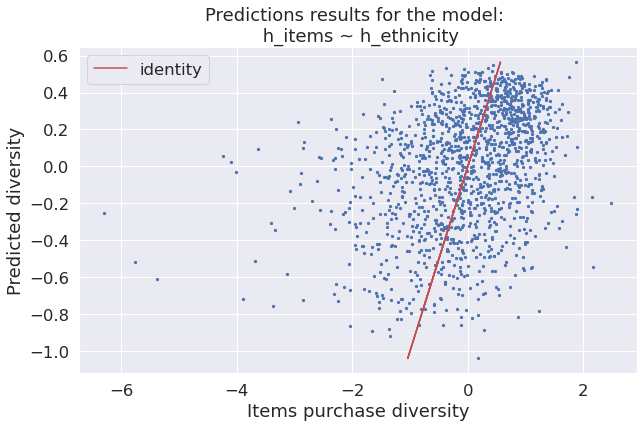

In [24]:
### NEW ERIC

fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(y_test, olsres.predict(X_test), s=5, c='b');
plt.plot(olsres.predict(X_test), olsres.predict(X_test), c='r', label='identity')
plt.legend()
plt.xlabel('True food purchase entropy')
plt.ylabel('Predicted food purchase entropy')
plt.title('Predictions results for the model: \n h_items ~ h_ethnicity')
plt.show()


We will now try to explain the variance in the food purchase entropy (`h_items`) with the following features of each LSOA:
- The ethnic entropy: `h_ethnicity`
- The employment rate: `employment_rate`
- The average age: `avg_age`
- The median income per household: `median_household_income`

The results will give us an idea about the contribution and significance of each term when predicting the value of `h_items`

In [25]:
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df[['h_ethnicity', 'employment_rate', 
                                                               'avg_age', 'median_household_income']],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsmod = sm.OLS(y_train, X_train)
olsres = olsmod.fit()
print(olsres.summary())

                            OLS Regression Results                            
Dep. Variable:                h_items   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     181.2
Date:                Thu, 17 Dec 2020   Prob (F-statistic):          7.46e-141
Time:                        17:34:10   Log-Likelihood:                -4487.8
No. Observations:                3383   AIC:                             8986.
Df Residuals:                    3378   BIC:                             9016.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

---

# NEW ERIC

When adding the employment rate, the median household income and the average age of the LSOA's population in the predicting factors, $R^2$ only rises from 11.2 to 17.7 %. This seems to suggest that the ethnic entropy has a non-negligible effect on the food purchase category entropy. However, it is still a naive approach to the study of causality, and we will need to perform more sophisticated tests to ensure that confounders are not the cause for these results.

Let us plot again the predicted and true food purchase entropy, obtained from this second model.

In [1]:
### NEW ERIC

fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(y_test, olsres.predict(X_test), s=5, c='b');
plt.plot(olsres.predict(X_test), olsres.predict(X_test), c='r', label='identity')
plt.legend()
plt.xlabel('True food purchase entropy')
plt.ylabel('Predicted food purchase entropy')
plt.title('Predictions results for the model: \n h_items ~ h_ethnicity + employment_rate + avg_age + median_household_income')
plt.show()

NameError: name 'plt' is not defined

# NEW ERIC

From these results using linear regressions, it looks like all four predictive factors have a significant effect on the food purchase entropy. They suggest the following conclusions:
- LSOA with more ethnic diversity tend to have a larger food purchase diversity
- LSOA with a higher employment rate tend to have a larger food purchase diversity
- LSOA with a higher average age tend to have a lower food purchase diversity
- LSOA with a larger median income per household tend to have a lower food purchase diversity

As the features are standardized, the magnitude of their coefficients can be directly compared. This suggests that `median_household_income` impacts `h_items` the most, followed by `h_ethnicity`, `employment_rate` and finally `avg_age`. Even though it seems that ethnic diversity has an effect on food purchase diversity in an LSOA, we still need to be careful with the conclusions we might take here. Indeed, we could be in a situation where for example the `median_household_income` feature is a confounder and therefore it influences both `h_items` and `h_ethnicity`. We could therefore see an effect of `h_ethnicity` on `h_items`, even though it is actually `median_household_income` which impacts both indirectly. In this case, the effect of `h_ethnicity` on `h_items` could entirely be explained by `median_household_income`. To ensure that we are not in such a situation, we will use the notion of matching. We will perform Generalized Propensity Score (GPS) matching. This will allow us to take into account and remove the effect of potential confounders in the analysis of the ethnic entropy's effect on food purchase entropy.

### 7.2. Propensity Score matching

#### Towards propensity score matching with a continuous treatment feature

In the ADA course, we learned about propensity score matching. It is very useful to minimize the impact of confounders on the analysis of the effect of a feature (called the treatment) on another feature (called the output). Indeed, until now, we have focused on simple and naive correlations, giving no information about causality whatsoever, as well as linear regressions which only slightly bring a notion of causality in the analysis. To dig deeper in the analysis of the effect of ethnic diversity on food purchase diversity and to know if causality is involved here, we will perform a propensity score matching. The goal is to match samples together using a propensity score, which represents the probability that a sample has been treated (treatment value = 1, in opposition to 0 when not treated) based on the values of some of its other features (the ones used to compute the score). 

However, in the ADA course, propensity score matching was performed with a binary treatment feature. This makes it a lot easier. Indeed, by default it cuts the dataset in two groups whose respective samples can then be matched together. In this present case, the treatment we would like to study is the ethnic entropy, a continuous feature. As the dataset cannot really be cut in the same manner when using a continuous treatment feature, it is not as straightforward as the binary case. Of course, there is always the solution of binarizing the continuous feature. It can simply be done by setting a threshold in the treatment feature: the samples with a higher value form the first group and the samples with an equal or lower value form the second group. This solution has a critical drawback though: it makes it very difficult to interpret the results of the treatment effect. Indeed, if the matching works well, and in the end a significant effect is found, it means the following thing: if a sample belongs to the first group, the output feature is significantly larger/lower (depending on the effect of the treatment) than it would be if this sample was in the second group (and therefore if its treatment was lower). Let us say that the threshold is set such that the two resulting groups have the same size. As groups are formed via a threshold on a continuous feature, it means that being in the top 50 % of samples in terms of the treatment feature value impacts a sample's output feature. But what about a sample at 49 % compared to one at 51 %? Is there really such a hard boundary? In most cases, no. Indeed, the threshold is often arbitrary in the case of a continuous feature. 

To account for the fact that the treatment feature is continuous, we decided to use an implementation of **Generalized Propensity Score (GPS)** matching. Matching is performed on two values: the propensity score of the sample, computed using a regression on the features selected to build the score (potential confounders whose effect needs to be minimized), and its continuous treatment value. Similar samples on these two values are matched together. The output of the algorithm is called a Causal Dose Response (CDR) curve. It computes the effect of the treatment on the output by calculating the predicted output value in function of the treatment value. If the treatment has an effect, then the curve is not flat, i.e. the predicted output changes depending on the treatment. The GPS algorithm outputs a confidence interval and we can use it to assess the significance of the resulting CDR curve.

# NEW ERIC

First, we need to filter the full dataset once again to keep only the numerical features for our the propensity score matching analysis.

# DEVELOPP (Max)

In [27]:
filtered_df = full_df.loc[:, 'h_items_norm':'people_per_sq_km']
filtered_df = pd.concat([ filtered_df, full_df.loc[:, 'Households;All_households;2011':'h_household_compo_norm']], axis=1)
filtered_df = pd.concat([ filtered_df, full_df.loc[:, 'Ethnic_Group;h_ethnicities_norm;2011':]], axis=1)
filtered_df.drop(['Country_of_Birth;ratio_Not_United_Kingdom;2011'], axis=1, inplace=True)
filtered_df.drop(['Household_Language;ratio_of_households_where_no_people_aged_16_or_over_have_English_as_a_main_language;2011'], axis=1, inplace=True)
#filtered_df.drop(['Country_of_Birth;ratio_Not_United_Kingdom;2011'], axis=1, inplace=True)

print(filtered_df.shape)
filtered_df

(4833, 83)


,h_items_norm,representativeness_norm,transaction_days,num_transactions,man_day,population,male,female,age_0_17,age_18_64,...,Health;Bad_or_Very_Bad_health_(ratio);2011,h_health_state_norm,Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;1_car_or_van_in_household_(ratio);2011,Car_or_van_availability;2_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;3_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;4_or_more_cars_or_vans_in_household_(ratio);2011,h_car_avail_norm,"Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)","Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)"
LSOA11NM,,,,,,,,,,,,,,,,,,,,,
City of London 001A,0.754474,0.284288,364.0,106255.0,16033.0,1296.0,685.0,611.0,179.0,766.0,...,0.020,0.371141,0.592,0.325,0.061,0.017,0.005,0.585298,74846.0,58347.0
City of London 001B,0.760816,0.211394,364.0,66016.0,7829.0,1156.0,616.0,540.0,197.0,656.0,...,0.027,0.351274,0.580,0.353,0.046,0.016,0.006,0.572880,73325.0,57159.0
City of London 001C,0.794262,0.242094,365.0,96567.0,15065.0,1350.0,713.0,637.0,152.0,850.0,...,0.062,0.557739,0.802,0.181,0.013,0.002,0.001,0.349270,44130.0,34387.0
City of London 001E,0.781864,0.412036,364.0,234504.0,25128.0,1121.0,604.0,517.0,294.0,675.0,...,0.073,0.584857,0.762,0.214,0.019,0.004,0.000,0.394205,30781.0,24000.0
Barking and Dagenham 016A,0.780443,0.165698,364.0,68269.0,5860.0,2040.0,1040.0,1000.0,563.0,1317.0,...,0.042,0.444476,0.343,0.459,0.160,0.026,0.013,0.726344,46141.0,39141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Greenwich 007F,0.813316,0.226103,364.0,191803.0,17579.0,1701.0,902.0,799.0,335.0,1241.0,...,0.027,0.321358,0.439,0.465,0.084,0.010,0.002,0.611401,48387.0,37255.0
Greenwich 002H,0.802985,0.107918,364.0,97859.0,9817.0,2426.0,1225.0,1201.0,844.0,1494.0,...,0.033,0.339171,0.383,0.465,0.136,0.015,0.002,0.665071,39272.0,30237.0
Greenwich 007G,0.812829,0.263697,364.0,215229.0,18734.0,1900.0,964.0,936.0,549.0,1220.0,...,0.075,0.547768,0.466,0.426,0.093,0.009,0.006,0.629609,35936.0,27670.0


We then standardize the dataset. Indeed, each feature is continuous and therefore we can directly perform it on the whole dataframe.

In [28]:
std_df = (filtered_df - filtered_df.mean()) / filtered_df.std()
std_df.sample(5)

,Adults_in_Employment;ratio_of_households_with_no_adults_in_employment:_With_dependent_children;2011,Car_or_van_availability;1_car_or_van_in_household_(ratio);2011,Car_or_van_availability;2_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;3_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;4_or_more_cars_or_vans_in_household_(ratio);2011,Car_or_van_availability;No_cars_or_vans_in_household_(ratio);2011,Country_of_Birth;ratio_United_Kingdom;2011,"Dwelling_type;Flat,_maisonette_or_apartment_(ratio);2011",Dwelling_type;Household_spaces_with_at_least_one_usual_resident_(ratio);2011,Dwelling_type;Household_spaces_with_no_usual_residents_(ratio);2011,...,h_qualif_norm,h_religion_norm,h_tenure_norm,male,man_day,num_transactions,people_per_sq_km,population,representativeness_norm,transaction_days
LSOA11NM,,,,,,,,,,,,,,,,,,,,,
Barking and Dagenham 023C,0.571070,0.082482,-0.254498,-0.362564,-0.506213,0.187136,0.930626,-1.086903,0.603786,-0.603804,...,0.045583,-0.343643,0.471328,-0.083317,-0.698294,-0.668802,-0.005887,0.061186,-0.687065,0.325182
Kingston upon Thames 010C,-0.964243,0.696091,0.537648,-0.129943,-0.101280,-0.558156,1.179043,-0.420382,0.329334,-0.329361,...,-0.207371,-0.728899,0.654315,0.569501,-0.911024,-0.825626,-0.950370,0.431559,-1.560779,-4.807590
Lambeth 013A,0.571070,-1.395190,-1.046643,-0.894271,-0.668187,1.348280,-0.118246,0.456977,0.542797,-0.542816,...,-0.266157,-0.662504,-0.553391,-1.122805,-0.289184,-0.394884,0.304667,-1.096571,-0.308571,0.325182
Hounslow 019C,-0.708358,1.009157,0.750917,1.564874,0.708588,-1.136028,-0.428768,-1.032493,0.664775,-0.664791,...,0.603136,1.569761,-0.088658,0.383699,-0.801460,-0.775657,-0.411161,0.266949,-0.740309,-0.285862
Hillingdon 015A,-0.708358,0.708613,0.375156,0.567923,0.222668,-0.612163,-0.035440,-0.195941,0.115871,-0.115905,...,-0.378912,0.966751,0.780455,9.432765,-0.738991,-0.667507,-0.778577,7.693606,-1.464105,0.325182


# NEW ERIC

The goal is now to select the features that we want to use in the propensity score, because we do not want to use all the features in the current dataframe. The output feature (i.e. the one we want to predict in the end) is the standardized version of `h_items_norm`, and we will therefore compute the Spearman correlation between this feature and all the other features. This is our way of filtering the features that will be used to compute the propensity score. Indeed, the goal is to include the features that are most likely to be confounders for the effect of ethnic diversity on food purchase diversity.

In [29]:
n_features = std_df.shape[1]

correl_df = pd.DataFrame(0, index=range(n_features-1), columns=['feature', 'correlation', 'p_value'])
feature_list = std_df.columns.tolist()
feature_list.remove('h_items_norm') 
correl_df['feature'] = feature_list

for i, col in enumerate(feature_list):
    correl, pval = spearmanr(std_df['h_items_norm'], std_df[col])
    correl_df.loc[i, 'correlation'] = correl
    correl_df.loc[i, 'p_value'] = pval

correl_df.head()

,feature,correlation,p_value
0,Adults_in_Employment;ratio_of_households_with_...,0.402207,2.178904e-187
1,Car_or_van_availability;1_car_or_van_in_househ...,-0.127561,5.479353e-19
2,Car_or_van_availability;2_cars_or_vans_in_hous...,-0.328573,4.965303e-122
3,Car_or_van_availability;3_cars_or_vans_in_hous...,-0.307831,1.359370e-106
4,Car_or_van_availability;4_or_more_cars_or_vans...,-0.305167,1.066943e-104


# NEW ERIC

Let us now discard the features for which the correlation with the output feature is not significant (i.e. their associated p-value > $\frac{0.05}{N}$ with $N$ the number of tests performed)

In [30]:
# keep only the significant data
# Bonferroni adjusted alpha
n_test = len(correl_df)
alpha_adj = 0.05/n_test

filtered_correl_df = correl_df[ correl_df['p_value'] < alpha_adj ]

filtered_correl_df.shape

(74, 3)

Let's now sort the features from the most to the least correlated to `h_items_norm`, using the absolute value of the correlation coefficent.

In [31]:
filtered_correl_df.insert(2,"abs_correlation", np.abs(filtered_correl_df['correlation']))
sorted_correl_df = filtered_correl_df.sort_values('abs_correlation', ascending=False)
sorted_correl_df.head(10)

,feature,correlation,abs_correlation,p_value
30,Household_Composition;ratio_Lone_parent_househ...,0.453982,0.453982,1.938682e-244
16,Economic_Activity;Economically_active:_Unemplo...,0.425294,0.425294,1.344982e-211
18,Economic_Activity;Unemployment_ratio;2011,0.417047,0.417047,9.912293e-203
55,Tenure;Owned_outright_(ratio);2011,-0.415181,0.415181,9.295447e-201
58,Tenure;Social_rented_(ratio);2011,0.412346,0.412346,8.727722e-198
0,Adults_in_Employment;ratio_of_households_with_...,0.402207,0.402207,2.178904e-187
29,Household_Composition;ratio_Couple_household_w...,-0.378579,0.378579,1.593143e-164
71,h_household_compo_norm,0.369545,0.369545,2.856378e-156
19,Ethnic_Group;h_ethnicities_norm;2011,0.368818,0.368818,1.285898e-155
33,"Household_Income,_2011/12;Mean_Annual_Househol...",-0.352765,0.352765,1.258317e-141


# NEW ERIC --> in the code below we should first print the 10 main features and then add h_items_norm

Let's keep the top $M$ features for the Generalized Propensity Score computation. In this case, to simplify the readability and level of interpretation of the following results, we will use $M$ = 10. After that, we will modularize this whole procedure, and we will be able to test other values of $M$.

In [2]:
main_features = sorted_correl_df.head(10)['feature'].tolist()
main_features.append('h_items_norm')
features_df = std_df[main_features]
features_df.columns

NameError: name 'sorted_correl_df' is not defined

# NEW ERIC

The 10 features with the largest correlations with the standarized `h_items_norm` are printed above.  It turns out that the treatment feature (the ethnic entropy) is among the features kept. If it was not the case, it would not be a problem. However, it is encouraging for the rest of the analysis.

Let us take this opportunity to briefly describe these important features:
- `Household_Composition;ratio_Lone_parent_household;2011`: the proportion of households with lone parents
- `Economic_Activity;Economically_active:_Unemployed;2011`: the proportion of econonmically active people which are unemployed
- `Economic_Activity;Unemployment_ratio;2011`: VA T-IL RESTER DANS L'ANALYSE ?!
- `Tenure;Owned_outright_(ratio);2011`: the proportion of tenure that are owned
- `Tenure;Social_rented_(ratio);2011`: the proportion of tenure that are social rented
- `Adults_in_Employment;ratio_of_households_with_no_adults_in_employment:_With_dependent_children;2011`: out of all households with no adults employed, it represents the proportion that have dependent children
- `Household_Composition;ratio_Couple_household_without_dependent_children;2011`: the proportion of households which consist in a couple without dependent children
- `h_household_compo_norm`: the entropy of household compositions, which can either be:
    - Couple household with dependent children
    - Lone parent household
    - One person household
    - Other multi-person houshold
- `Ethnic_Group;h_ethnicities_norm;2011`: the entropy of the ethnicity, which is the treatment feature
- `Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)`: the mean annual household income estimate, in pounds

We observe that we end up with 9 socio-economic features, which are potential confounders. They will be used to determine if ethnic diversity has a causal effect on food purchase diversity.

In [33]:
features_df = features_df.rename(columns={"Household_Composition;ratio_Lone_parent_household;2011": "lone_parents",
                            "Economic_Activity;Economically_active:_Unemployed;2011": "unemployed", 
                            "Economic_Activity;Unemployment_ratio;2011": "unemployment",
                            "Tenure;Owned_outright_(ratio);2011": "owned_tenure",
                            "Tenure;Social_rented_(ratio);2011": "social_rented_tenure",
                            "Adults_in_Employment;ratio_of_households_with_no_adults_in_employment:_With_dependent_children;2011":
                            "households_no_adults_employed",
                            "Household_Composition;ratio_Couple_household_without_dependent_children;2011": 
                            "couple_household_no_children",
                            "Ethnic_Group;h_ethnicities_norm;2011": "h_ethnic",
                            "Household_Income,_2011/12;Mean_Annual_Household_Income_estimate_(£)": "household_mean_income"})

# NEW ERIC

We will now perform the Generalized Propensity Score (GPS) matching. We found it already implemented online and decided to use it as is. We will ensure to compare multiple results to confirm that it is useful in the current analysis. After some initial experiments, we found good parameters to run this algorithm. The `treatment_grid_num` parameter controls the discretization of the treatment feature value. `lower_grid_constraint` and `upper_grid_constraint` control the lower and upper quantile between which the matching is performed. Indeed, we realized that by using all the values, the results can get biased, as the density of datapoints of ethnic entropy (the treatment feature) is lower near the minimum and maximum values of the feature. By setting this interval as 0.2-0.8, we capture 60% of data, where it is densed enough to perform matching. 

In other cases, using 0.05-0.95 and capturing 90% of the data is feasible, but in this dataset we do not have enough datapoints (LSOA) for this. 

In [36]:
gps = GPS(gps_family=None,
          treatment_grid_num=100,
          lower_grid_constraint=0.2,
          upper_grid_constraint=0.8,
          spline_order=3,
          n_splines=15, # maximum number of turning points (knots) to be used during the smoothing process
          lambda_=0.5,
          max_iter=500,
          random_seed=None,
          verbose=False)

features = features_df.columns.to_list()
features.remove('h_items_norm')
#features.remove('h_ethnic')

treat_feat = 'h_ethnic'
features.remove(treat_feat)

# Fits the causal dose-response model.
gps.fit(T = features_df[treat_feat], 
        X = features_df[features], 
        y = features_df['h_items_norm'])

gps_results = gps.calculate_CDRC(0.95)

# NEW ERIC

We will now plot the output of the GPS matching, which gives information about the treatment effect.

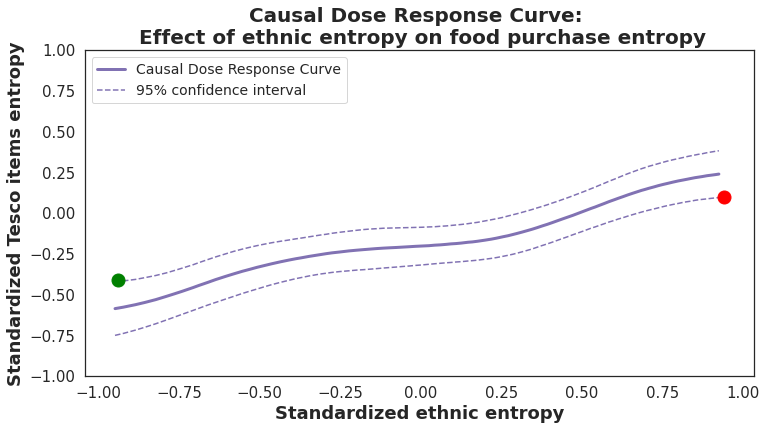

In [37]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(gps_results['Treatment'], gps_results['Causal_Dose_Response'], label='Causal Dose Response Curve',
         c='m', linewidth=3)
plt.plot(gps_results['Treatment'], gps_results['Lower_CI'], 'm--', label='95% confidence interval')
plt.plot(gps_results['Treatment'], gps_results['Upper_CI'], 'm--')
plt.ylim(-1,1)
ax.legend()
plt.title('Causal Dose Response Curve: \n Effect of ethnic entropy on food purchase entropy',
          fontsize=20, fontweight='bold')
plt.xlabel('Standardized ethnic entropy', fontsize=18, fontweight='bold')
plt.ylabel('Standardized Tesco items entropy', fontsize=18, fontweight='bold')

# plot points to highlight how the metric we will use works
plt.plot([-0.94], [-0.41], marker='o', markersize=13, color="green")
plt.plot([0.94], [0.1], marker='o', markersize=13, color="red")

plt.tick_params(labelsize=15)

plt.legend(loc=2, prop={'size': 14})

plt.show()

To measure the significance of the effect of ethnic entropy on food purchase entropy, we thought about a metric. It is quite straightforward and surely it already exists, but we have not been able to find anyone else using or defining it.

Let us look at the plot above to define this metric on a concrete example. In this case, the CDR curve has an approximately constant positive slope. We observe that no horizontal line can be drawn inside the confidence interval (CI). As a horizontal line corresponds to the treatment having no effect on the output, in the case of the curve above we interpret that the effect of the treatment on the output is significant.

Now, how can we capture this information using a simple and robust metric? If we look at the difference between the maximum value of the lower CI (the red dot on the plot) and the minimum value of the upper CI (the green dot), we observe that in this case it is positive. Indeed, the red dot has a larger y-value (standarized `h_items`) than the green dot. By definition, this difference being positive verifies that no horizontal line can be drawn inside the CI. Since we took the 95% CI, not being able to draw an horizontal line fully contained within the CI ensures that there is less than 5% chance of wrongly rejecting the null hypothesis (type I error) of having no causality between the two features.  

Here is the value of the metric in this case:

In [38]:
treatment_effect_metric = (gps_results['Lower_CI'].max() - gps_results['Upper_CI'].min())
print("The causality significance metric has a value of {0:.3f}.".format(treatment_effect_metric))

The causality significance metric has a value of 0.516.


# NEW ERIC

There we have it: the GPS matching results suggest that ethnic diversity indeed has an effect on food purchase diversity. By looking at the CDR curve, we observe that the relation is almost linear, and therefore that the more ethnic diversity is present in an LSOA, the higher will be the food purchase diversity. Before analyzing and interpreting this result, let us first finish presenting the causal significance metric.

Let us compare this example to another one, to better grasp how this metric works. Here is the CDR curve, with the number of male in the area as a treatment feature.

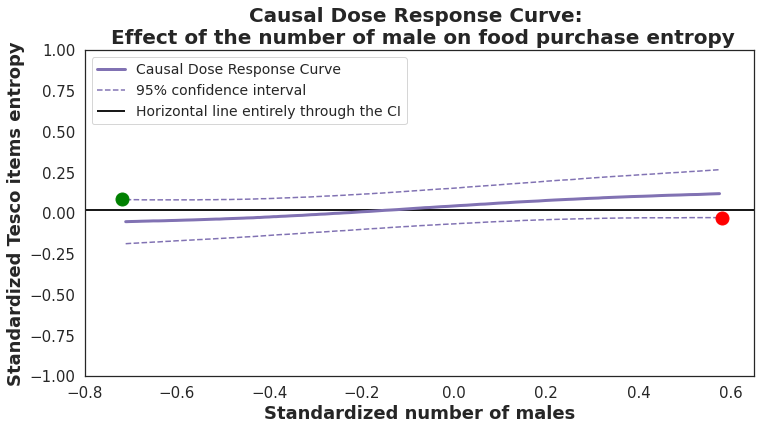

In [39]:
gps = GPS(gps_family=None, treatment_grid_num=100, lower_grid_constraint=0.2, upper_grid_constraint=0.8, spline_order=3,
          n_splines=15, lambda_=0.5, max_iter=500, random_seed=None, verbose=False)

features = features_df.columns.to_list()
features.remove('h_items_norm')

treat_feat = 'male'

gps.fit(T = std_df[treat_feat], X = features_df[features], y = features_df['h_items_norm'])
gps_results = gps.calculate_CDRC(0.95)

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(gps_results['Treatment'], gps_results['Causal_Dose_Response'], label='Causal Dose Response Curve', c='m', linewidth=3)
plt.plot(gps_results['Treatment'], gps_results['Lower_CI'], 'm--', label='95% confidence interval')
plt.plot(gps_results['Treatment'], gps_results['Upper_CI'], 'm--')
plt.plot([-0.72], [0.09], marker='o', markersize=13, color="green")
plt.plot([0.58], [-0.03], marker='o', markersize=13, color="red")
plt.hlines(0.02, -1, 1, color='k', linewidth=2, label='Horizontal line entirely through the CI')

plt.title('Causal Dose Response Curve: \n Effect of the number of male on food purchase entropy', fontsize=20, fontweight='bold')
plt.xlabel('Standardized number of males', fontsize=18, fontweight='bold')
plt.ylabel('Standardized Tesco items entropy', fontsize=18, fontweight='bold')

ax.legend()
plt.ylim(-1,1)
plt.xlim(-0.8,0.65)
plt.tick_params(labelsize=15)
plt.legend(loc=2, prop={'size': 14})

plt.show()

We can observe that in this case, the green dot has a larger y-value compared to the red dot, in turn meaning that the metric is negative. It is clear that a horizontal line can be drawn inside the CI, as shown by the black line; therefore we rate the effect of this treatment as non significant.

In [40]:
treatment_effect_metric = (gps_results['Lower_CI'].max() - gps_results['Upper_CI'].min())
print("The causality significance metric has a value of {0:.3f}.".format(treatment_effect_metric))

The causality significance metric has a value of -0.109.


The more positive this metric is, the more significant is the effect of the treatment. We do not need to normalize it, as we are already working with a standardized dataframe. In the two examples presented, the max of the lower CI and the min of the upper CI are on the bounds of the interval. Even when this is not the case, the metric still works just fine. Indeed, if we imagine a parabolic CDR curve, the metric will still be negative if a horizontal line can be drawn in the CI, and positive if not. 

# NEW ERIC

This metric is really interesting thanks to the visual intuition it represents and to its simplicity. However, it two slight drawbacks: it cannot retrieve the sign of the causal effect and it cannot always capture the magnitude of the treatment effect on the output. Indeed, if the CDR curve is not well estimated by a linear regression (i.e. if it does not look like a line), the value of the _causality significance metric_ could minimize the effect of the treatment. It will always be proportional to the difference between the highest estimated output value in function of the treatment, and its lowest estimated value (because the CI englobes the CDR curve and follows its variations), which is already interesting enough to give an idea of treatment effect magnitude.

#### Modularity

We have now seen in details with the ethnic and food purchase entropies, how we can analyze those features to go from a correlation, telling us how strong the association between the two variables is, to a causality link between them. 
Let's create some functions to perform those analyses in a more condensed way, allowing us to test the causality link between many features appearing to be correlated or not.

# NEW ERIC

To do so, we will use two functions.
- `compute_corr_df()`: Returns a standardized dataframe of the $M$ most correlated features to an outcome feature, as well as a dataframe with the same features but not standardized
- `compute_GPS()`: Compute the Generalized Propensity Score between a treatment and an outcome feature, considering all the other features present in the dataframe as confounding factors. Returns our causality metric as well as the points of the causal dose response curve

In [41]:
##### Function to determine the most correlated features #####
def compute_corr_df(df, treatment_name, outcome_name, n=30, alpha=0.05):
    '''
    Standardize the df
    Compute the correlation between each features of the df and the outcome feature
    Select the significative correlations (for alpha)
    Return a df of only the n most correlated features & the outcome feat
    (& the treatment if not in the most correlated features) 
    Return another df, that is similar but not standardized
    '''
    
    # standardize the df
    std_df = (df - df.mean()) / df.std()
    
    correl_df = pd.DataFrame(0, index=range(df.shape[1]-1), columns=['feature', 'correlation', 'p_value'])
    features = list(df.columns.values)
    features.remove(outcome_name)  
    correl_df['feature'] = features
    
    # compute the correlation on the standardized df
    for i, col in enumerate(features):
        correl, pval = spearmanr(std_df[outcome_name], std_df[col])
        correl_df.loc[i, 'correlation'] = correl
        correl_df.loc[i, 'p_value'] = pval
        
    alpha_adj = alpha/len(correl_df)
    filtered_correl_df = correl_df[correl_df['p_value'] < alpha_adj]
    filtered_correl_df.insert(2,"abs_correlation", np.abs(filtered_correl_df['correlation']))
    sorted_correl_df = filtered_correl_df.sort_values('abs_correlation', ascending=False)
    
    main_features = sorted_correl_df.head(n)['feature'].tolist()
    main_features.append(outcome_name)
    
    ## Check if the treatment is one of the most correlated features, otherwise add it
    if not treatment_name in main_features:
        main_features.append(treatment_name)
    
    corr_features_df = df[main_features]
    std_corr_features_df = std_df[main_features]
    
    return corr_features_df, std_corr_features_df



##### Function to compute the Generalized propensity Score #####

def compute_GPS(df, std_df, treatment_name, outcome_name, plot_std=False, plot_normal=False, CI=0.95, 
                ymin_std=-1, ymax_std=1):
    '''
    Compute the generalized propensity score to determine the Causal Dose Response Curve
    between the treatment and the outcome, considering the other features of the df as confounders
    '''
    gps = GPS(treatment_grid_num=100, lower_grid_constraint=0.2, upper_grid_constraint=0.8, n_splines=15)
    
    features = std_df.columns.to_list()
    features.remove(treatment_name)
    features.remove(outcome_name)

    # Fits the causal dose-response model.
    gps.fit(T = std_df[treatment_name], 
            X = std_df[features], 
            y = std_df[outcome_name])
    
    gps_results = gps.calculate_CDRC(CI)
    
    if plot_std:
        fig, ax = plt.subplots(figsize=(12,6))
        plt.plot(gps_results['Treatment'], gps_results['Causal_Dose_Response'], 
                 label='Causal Dose Response Curve', linewidth=3)
        plt.plot(gps_results['Treatment'], gps_results['Lower_CI'], 'k--', label='95% confidence interval')
        plt.plot(gps_results['Treatment'], gps_results['Upper_CI'], 'k--')
        plt.ylim(ymin_std,ymax_std)
        plt.xlim(-1,1)
        ax.legend()
        plt.title('Causal Dose Response Curve')
        plt.xlabel('Standardized Treatment: ' + treatment_name)
        plt.ylabel('Standardized Outcome: ' + outcome_name)
        plt.show()
        
    if plot_normal:
        
        # destandardize the values
        treat_destd = gps_results['Treatment']*np.std(df[treatment_name]) + np.mean(df[treatment_name])
        
        std_out = np.std(df[outcome_name])
        mean_out = np.mean(df[outcome_name])
        cdr_destd = gps_results['Causal_Dose_Response']*std_out + mean_out
        cdr_destd_low95 = gps_results['Lower_CI']*std_out + mean_out
        cdr_destd_up95 = gps_results['Upper_CI']*std_out + mean_out
        
        #plot
        fig, ax = plt.subplots(figsize=(12,6))
        plt.plot(treat_destd, cdr_destd, label='Causal Dose Response Curve',linewidth=3)
        plt.plot(treat_destd, cdr_destd_low95, 'k--', label='95% confidence interval')
        plt.plot(treat_destd, cdr_destd_up95, 'k--')
        ax.legend()
        plt.title('Causal Dose Response Curve')
        plt.xlabel('Treatment: ' + treatment_name)
        plt.ylabel('Outcome: ' + outcome_name)
        plt.show()
    
    treatment_effect_metric = (gps_results['Lower_CI'].max() - gps_results['Upper_CI'].min())
    
    return gps_results, treatment_effect_metric


### 7.3. Assessing our approach

# NEW ERIC

We will now come back to the analysis of the results of the GPS matching.

In [3]:
# replotter résultat

# NEW ERIC

We have observed that using the 10 features being the most correlation with the outcome feature (i.e. food purchase entropy) to compute the propensity score results in a significant treatment (i.e. ethnic entropy) effect. However, the choice of considering only the 10 most correlated features as potential confounders is arbitrary. Therefore, let's check that this arbitrary choice has no influence on the conclusion drawn by looking at the causality significance metric that is obtained when considering a different value of $M$ (i.e. the value controlling the number of top correlated features that are used as confounding factors in the GPS matching procedure). We will test values ranging from $M = 1$ to $M = 50$.

In [42]:
nb_corr_feat = range(1, 51)
caus_metric = []
treat_feat = 'Ethnic_Group;h_ethnicities_norm;2011'

for nb in nb_corr_feat:
    corr_features_df, std_corr_features_df =  compute_corr_df(filtered_df, treat_feat, 'h_items_norm', n=nb)
    _, treat_eff_met = compute_GPS(corr_features_df, std_corr_features_df, treat_feat, 'h_items_norm')
    caus_metric.append(treat_eff_met)

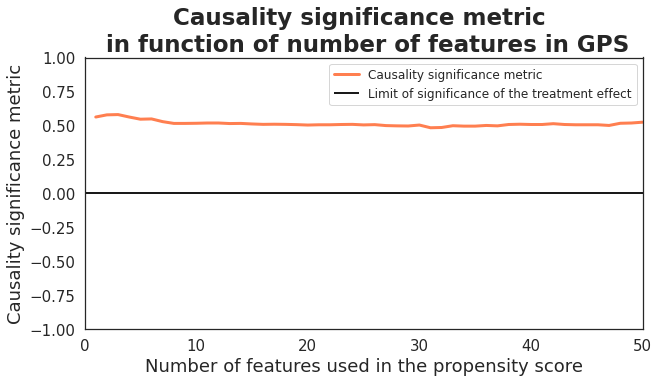

In [43]:
plt.figure(figsize=(10,5))

plt.plot(nb_corr_feat, caus_metric, linewidth=3, color='coral', label='Causality significance metric');
plt.hlines(0, -5, 65, colors='k', linewidth=2, label='Limit of significance of the treatment effect')

plt.title('Causality significance metric \n in function of number of features in GPS', fontsize=23, fontweight='bold')
plt.xlabel('Number of features used in the propensity score', fontsize=18)
plt.ylabel('Causality significance metric', fontsize=18)
plt.tick_params(labelsize=15)

plt.ylim(-1,1);
plt.xlim(0,50)

plt.legend()
plt.show()

# NEW ERIC

The causality significance metric does not change when considering more correlated features as potential confounders. This suggests that considering only the 10 most correlated features is enough to determine the causality significance between the treatment and the outcome, removing the effect of potential confounders. It is quite interesting, as it seems that the number of confounding factors used does not impact the causality significance of the ethnic diversity on the food purchase diversity. This suggests that the ethnic diversity does not have any real confounders in this dataset.

However, to ensure that this example is not an exception and that we are considering enough potential confounders for each analysis, for the following analyses we will take into account the 30 most correlated features to the outcome as potential confounders of the treatment.

Now let's check that not all the features correlated to the food purchase diversity appear to have a causality link with this latter. If it was the case, then it would mean that something went wrong in our analysis as we aim to identify what are the real causal links that can be observed from the correlated features and not just having another metric that is similar to the correlation. We will therefore perform GPS matching with $M = 30$ with each feature of the dataframe used in this causality analysis section as a treatment. In each case, we keep the food purchase entropy as the ouput feature. We will compute the causality significance in each case, and we will then be able to compare its value with the correlations computed in the correlation analysis section.

In [44]:
## First determine all the features correlated to the diversity in food purchase
## and their correlation value
outcome_name = 'h_items_norm'

# standardize the df
std_df = (filtered_df - filtered_df.mean()) / filtered_df.std()

correl_df = pd.DataFrame(0, index=range(filtered_df.shape[1]-1), 
                         columns=['feature', 'correlation', 'p_value'])

features = list(filtered_df.columns.values)
features.remove(outcome_name)  
correl_df['feature'] = features

# compute the correlation on the standardized df
for i, col in enumerate(features):
    correl, pval = spearmanr(std_df[outcome_name], std_df[col])
    correl_df.loc[i, 'correlation'] = correl
    correl_df.loc[i, 'p_value'] = pval
    
alpha_adj = 0.05/len(correl_df)

filtered_correl_df = correl_df[correl_df['p_value'] < alpha_adj]
filtered_correl_df.insert(2,"abs_correlation", np.abs(filtered_correl_df['correlation']))
sorted_correl_df = filtered_correl_df.sort_values('abs_correlation', ascending=False)

corr_features = sorted_correl_df['feature'].tolist()

In [45]:
sorted_correl_df

,feature,correlation,abs_correlation,p_value
17,Household_Composition;ratio_Lone_parent_househ...,0.453982,0.453982,1.938682e-244
52,Economic_Activity;Economically_active:_Unemplo...,0.425294,0.425294,1.344982e-211
55,Economic_Activity;Unemployment_ratio;2011,0.417047,0.417047,9.912293e-203
34,Tenure;Owned_outright_(ratio);2011,-0.415181,0.415181,9.295447e-201
36,Tenure;Social_rented_(ratio);2011,0.412346,0.412346,8.727722e-198
...,...,...,...,...
45,h_dwelling_norm,-0.082974,0.082974,7.612127e-09
31,Religion;No_religion_(ratio);2011,0.080159,0.080159,2.403181e-08
59,Qualifications;ratio_Highest_level_of_qualific...,0.075731,0.075731,1.356561e-07
23,Household_Language;ratio_of_households_with_at...,-0.072796,0.072796,4.059580e-07


# NEW ERIC

74 features have a significant correlation with the food purchase entropy, represented by the standardized version of `h_items_norm`.

In [46]:
# then compute the causality metric considering 30 potential confounders 
caus_metric = []

for treat_feat in corr_features:
    corr_features_df, std_corr_features_df =  compute_corr_df(filtered_df, treat_feat, 'h_items_norm')
    _, treat_eff_met = compute_GPS(corr_features_df, std_corr_features_df, treat_feat, 'h_items_norm')
    caus_metric.append(treat_eff_met)

In [47]:
corr_caus_df = sorted_correl_df[['feature', 'correlation']]
corr_caus_df.insert(2, 'caus_metric', caus_metric)
#is_causal = [True if met < 0 else False for met in caus_metric]
#corr_caus_df['is_causal'] = is_causal

In [48]:
corr_rank = range(1,len(sorted_correl_df)+1)
corr_caus_df['corr_rank'] = corr_rank

sort_caus_df = corr_caus_df.sort_values('caus_metric', ascending=False)
caus_rank = range(1,len(sort_caus_df)+1)
sort_caus_df['caus_rank'] = caus_rank

sort_df = sort_caus_df.sort_values('corr_rank', ascending=True)
sort_df['change_in_rank'] = sort_df['corr_rank'] - sort_df['caus_rank']

# NEW ERIC

The dataframe printed below shows the results for each feature. The causality significance metric is computed for each feature, when used as a treatment, with the food purchase entropy being the output feature. The correlation with the food purchase diversity is also displayed.

Moreover, the rankings of each feature in the strength of correlation with the food purchase diversity (`corr_rank`) and in the causality significance metric (`caus_rank`) are included. Finally, `change_in_rank` represents the number of ranks gained or losed (given by a positive or a negative number, respectively) by the feature from `corr_rank` to `caus_rank`.

In [49]:
# We change the Pandas parameters to be able to display the whole data

pd.set_option("display.max_rows", None, "display.max_columns", None)
display(sort_df)

,feature,correlation,caus_metric,corr_rank,caus_rank,change_in_rank
17,Household_Composition;ratio_Lone_parent_househ...,0.453982,0.480,1,5,-4
52,Economic_Activity;Economically_active:_Unemplo...,0.425294,0.514,2,2,0
55,Economic_Activity;Unemployment_ratio;2011,0.417047,0.458,3,6,-3
34,Tenure;Owned_outright_(ratio);2011,-0.415181,0.394,4,7,-3
36,Tenure;Social_rented_(ratio);2011,0.412346,0.543,5,1,4
48,Adults_in_Employment;ratio_of_households_with_...,0.402207,0.481,6,4,2
16,Household_Composition;ratio_Couple_household_w...,-0.378579,0.351,7,9,-2
20,h_household_compo_norm,0.369545,0.334,8,10,-2
21,Ethnic_Group;h_ethnicities_norm;2011,0.368818,0.503,9,3,6
80,"Household_Income,_2011/12;Mean_Annual_Househol...",-0.352765,0.267,10,16,-6


# NEW ERIC

These results are quite interesting. Here are a few take home messages:
- Ethnic entropy was 9$^{th}$ in the correlation strength rankings and jumps to 3$^{rd}$ in the causal significance ranking
- `Health;Very_good_or_Good_health_(ratio);2011` loses 40 places and ends up with a negative causality significance metric, which shows that its correlation with the food purchase entropy was actually due to confounders.
- The largest jump is recorded by `h_religion_norm` which represents religion diversity. Its correlation with the food purchase entropy is small, but nevertheless when removing the effect of confounders it results in having a significant effect on the output
- `Tenure;Social_rented_(ratio);2011` ends up first in the causality significance rankings

Let us have a quick look at the features we included in the second linear regression. Indeed, we thought these could be the main confounders of the analysis:
- `Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)` is ranked 11$^{th}$ and then 12$^{th}$. These results suggest that it has less impact on food purchase entropy than ethnic entropy.
- `avg_age` goes from 21$^{th}$ to 8$^{th}$, suggesting that its effect on food purchase entropy is less affected by confounders than most other features.
- Employment rate USED IN LINEAR REGRESSION? STILL IN DATASET? IDK

In [50]:
# We change back the Pandas parameters to reasonable values
pd.set_option("display.max_rows", 10, "display.max_columns", 20)

# NEW ERIC

Now that we have computed the causality significance metric for each feature in the current dataset, we can plot the distribution of the metric across the features. 

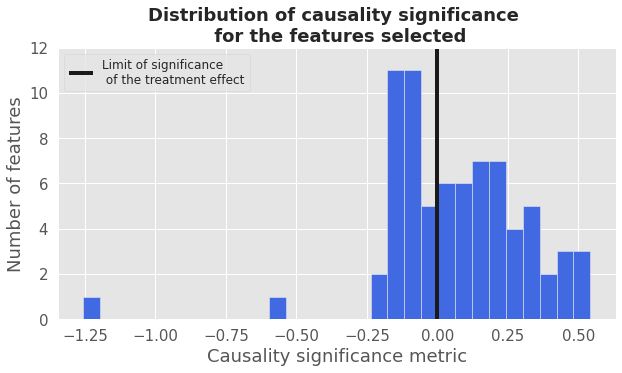

In [51]:
style.use('ggplot')

plt.figure(figsize=(10,5))
plt.hist(caus_metric, color='royalblue', bins=30)
plt.vlines(0,0,20, color='k', label="Limit of significance \n of the treatment effect", linewidth=4)
plt.title("Distribution of causality significance \n for the features selected", fontsize=18, fontweight='bold')
plt.xlabel('Causality significance metric', fontsize=18)
plt.ylabel('Number of features', fontsize=18)
plt.tick_params(labelsize=15)

plt.ylim(0,12)

#plt.legend()
plt.legend(loc=2)
plt.show()

# NEW ERIC

The features with a negative causality significance metric have a non significant effect on food purchase diversity. It is interesting because when computing the correlation between the features of the current dataset and the food purchase entropy, we isolated 74 features with a significant correlation. Now we observe that from these 74 features, only 43 actually have a causal effect on food purchase diversity. It means that 31 features have a significant correlation with the food purchase diversity, but when taking into account confounding factors we realize that the features have no causal effect on the food purchase diversity.

To better grasp the link between the correlations and the causality significance metrics computed and discussed previously, we will now plot each feature's results as a point on a correlation vs. causality significance metric graph.

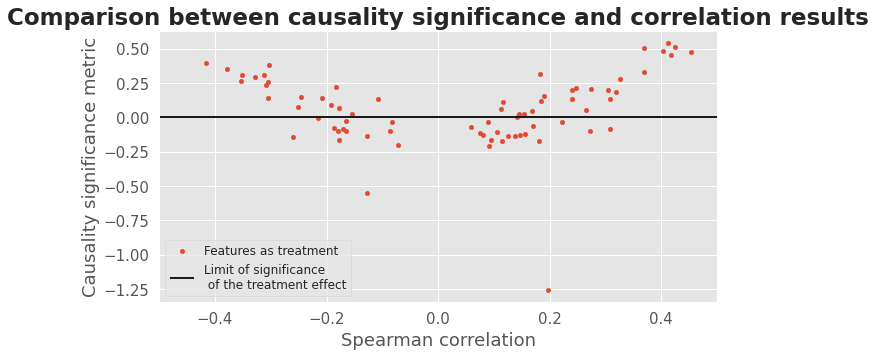

In [56]:
plt.figure(figsize=(10,5))

plt.scatter(corr_caus_df.correlation, corr_caus_df.caus_metric, s=20, label='Features as treatment')
plt.hlines(0, -0.7, 0.7, colors='k', linewidth=2, label='Limit of significance \n of the treatment effect');
#plt.hlines(-0.1, -0.5, 0.5, colors='m', Linestyle='--'); # safety factor ?
plt.xlabel('Spearman correlation', fontsize=18)
plt.ylabel('Causality significance metric', fontsize=18)
plt.title("Comparison between causality significance and correlation results", fontsize=23, fontweight='bold')

plt.xlim(-0.5, 0.5)
plt.tick_params(labelsize=15)

plt.legend()
plt.show()

# NEW ERIC

These results highlight some interesting results. For example, the fact that many features that are correlated to the food purchase diversity are in fact not showing any causality link with this feature when considering confounding factors. These are all the points below the black line at $y = 0$.


In addition, we can observe on the scatter that even though there is a trend showing that the more correlated (in absolute value), the more causal the relationship between the two variables is, this relation is not perfect. This is what we would have expected. Indeed, if the points were all located on the $y = A*|x|$ curve, with $A$ a constant, this would mean that the causality significance metric is simply another way of computing a correlation. This plot shows that features with a similar correlation can have different causality significance metrics. In some cases, two features with similar correlations lead to one feature having a causal link with food purchase entropy, and the other not, which showcases how useful GPS matching is in this analysis.

# NEW ERIC

## 7.4. Is our ethnicity reflected in our food purchase ? 

In [ ]:
treat_feat = 'Ethnic_Group;h_ethnicities_norm;2011'
corr_features_df, std_corr_features_df =  compute_corr_df(filtered_df, treat_feat, 'h_items_norm', n=10)
gps_results, treat_eff_met = compute_GPS(corr_features_df, std_corr_features_df, treat_feat, 'h_items_norm')

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(gps_results['Treatment'], gps_results['Causal_Dose_Response'], label='Causal Dose Response Curve',
         c='m', linewidth=3)
plt.plot(gps_results['Treatment'], gps_results['Lower_CI'], 'm--', label='95% confidence interval')
plt.plot(gps_results['Treatment'], gps_results['Upper_CI'], 'm--')
plt.ylim(-1,1)
ax.legend()
plt.title('Causal Dose Response Curve: \n Effect of ethnic entropy on food purchase entropy',
          fontsize=20, fontweight='bold')
plt.xlabel('Standardized ethnic entropy', fontsize=18, fontweight='bold')
plt.ylabel('Standardized Tesco items entropy', fontsize=18, fontweight='bold')

# plot points to highlight how the metric we will use works
plt.plot([-0.94], [-0.41], marker='o', markersize=13, color="green")
plt.plot([0.94], [0.1], marker='o', markersize=13, color="red")

plt.tick_params(labelsize=15)

plt.legend(loc=2, prop={'size': 14})

plt.show()

# NEW ERIC

Now that we have clearly identified that the more diverse the population is (in terms of ethnicity), the more diverse the food purchase will be, let's come back to another of our main questions of interest: Can we identify food categories that are an ethnicity purchases more specific to a certain ethnicity ? 

We have seen in the correlation analysis that the different ethnicities were correlated in specific manners to the different food categories. However, as it was done for the study done with the food purchase and ethnicity diversity, we would like to determine whether those correlations lead to causal links between the different features.

To determine this, we process in a similar manner than previously, computing a GPS between a treatment and an outcome to remove the effect of confounding factors allowing to identify a causality link between the features.

In [57]:
ethnic_features = ['Ethnic_Group;White_(ratio);2011',
                   'Ethnic_Group;Mixed/multiple_ethnic_groups_(ratio);2011',
                   'Ethnic_Group;Asian/Asian_British_(ratio);2011',
                   'Ethnic_Group;Black/African/Caribbean/Black_British_(ratio);2011',
                   'Ethnic_Group;Other_ethnic_group_(ratio);2011']

ethnic_feat_short = ['White', 'Mixed', 'Asian', 'Black', 'Other']

food_features = ['f_dairy', 'f_eggs', 'f_fats_oils', 'f_fish', 'f_fruit_veg', 
                 'f_grains', 'f_meat_red', 'f_poultry', 'f_readymade', 'f_sauces', 'f_sweets']

drink_features = ['f_beer', 'f_soft_drinks', 'f_spirits','f_tea_coffee', 'f_water', 'f_wine']

In [58]:
filtered_df.index = full_df.index
filtered_df = pd.concat([filtered_df, full_df.loc[:,food_features]], axis=1)
filtered_df = pd.concat([filtered_df, full_df.loc[:,drink_features]], axis=1)
filtered_df = pd.concat([filtered_df, full_df.loc[:,ethnic_features]], axis=1)

In [59]:
res_food_df = pd.DataFrame(columns=['out', 'treat', 'metric'])
caus_curve_food_df = pd.DataFrame(columns=['Treatment', 'Causal_Dose_Response', 
                                           'Lower_CI', 'Upper_CI', 'outcome', 'treatment', 'is_causal'])

for outcome in food_features:
    print(outcome)
    for i, treat in enumerate(ethnic_features):
        corr_features_df, std_corr_features_df =  compute_corr_df(filtered_df, treat, outcome)
        gps_res, treat_eff_metric = compute_GPS(corr_features_df, std_corr_features_df, treat, outcome)
        res_food_df = res_food_df.append({'out': outcome, 'treat': ethnic_feat_short[i], 
                                     'metric': treat_eff_metric}, ignore_index=True)  
        gps_res['outcome'] = np.repeat(outcome, 100)
        gps_res['treatment'] = np.repeat(ethnic_feat_short[i], 100)
        is_causal = (treat_eff_metric > 0)
        gps_res['is_causal'] = np.repeat(is_causal, 100)
        caus_curve_food_df = caus_curve_food_df.append(gps_res, ignore_index=True)

f_dairy
f_eggs
f_fats_oils
f_fish
f_fruit_veg
f_grains
f_meat_red
f_poultry
f_readymade
f_sauces
f_sweets


In [60]:
caus_curve_food_df

,Treatment,Causal_Dose_Response,Lower_CI,Upper_CI,outcome,treatment
0,-0.934,-0.084,-0.312,0.144,f_dairy,White
1,-0.899,-0.084,-0.312,0.144,f_dairy,White
2,-0.880,-0.085,-0.312,0.143,f_dairy,White
3,-0.859,-0.088,-0.314,0.139,f_dairy,White
4,-0.826,-0.095,-0.320,0.130,f_dairy,White
...,...,...,...,...,...,...
5495,0.468,-0.061,-0.179,0.057,f_sweets,Other
5496,0.468,-0.061,-0.179,0.057,f_sweets,Other
5497,0.503,-0.056,-0.177,0.065,f_sweets,Other
5498,0.539,-0.051,-0.175,0.073,f_sweets,Other


# NEW ERIC

We will now plot the CDR curve resulting from the GPS matching, for every pair of ethnicity and food/drink category. As in the correlation analysis section, we will plot the results for food categories and drink categories in separate plots, for readability purposes. It will give an idea of what CDR curves can look like, as well as allowing us to interpret the results better. As all features used are standardized, all plots have the same axes scales, which simplifies comparisons of the results.

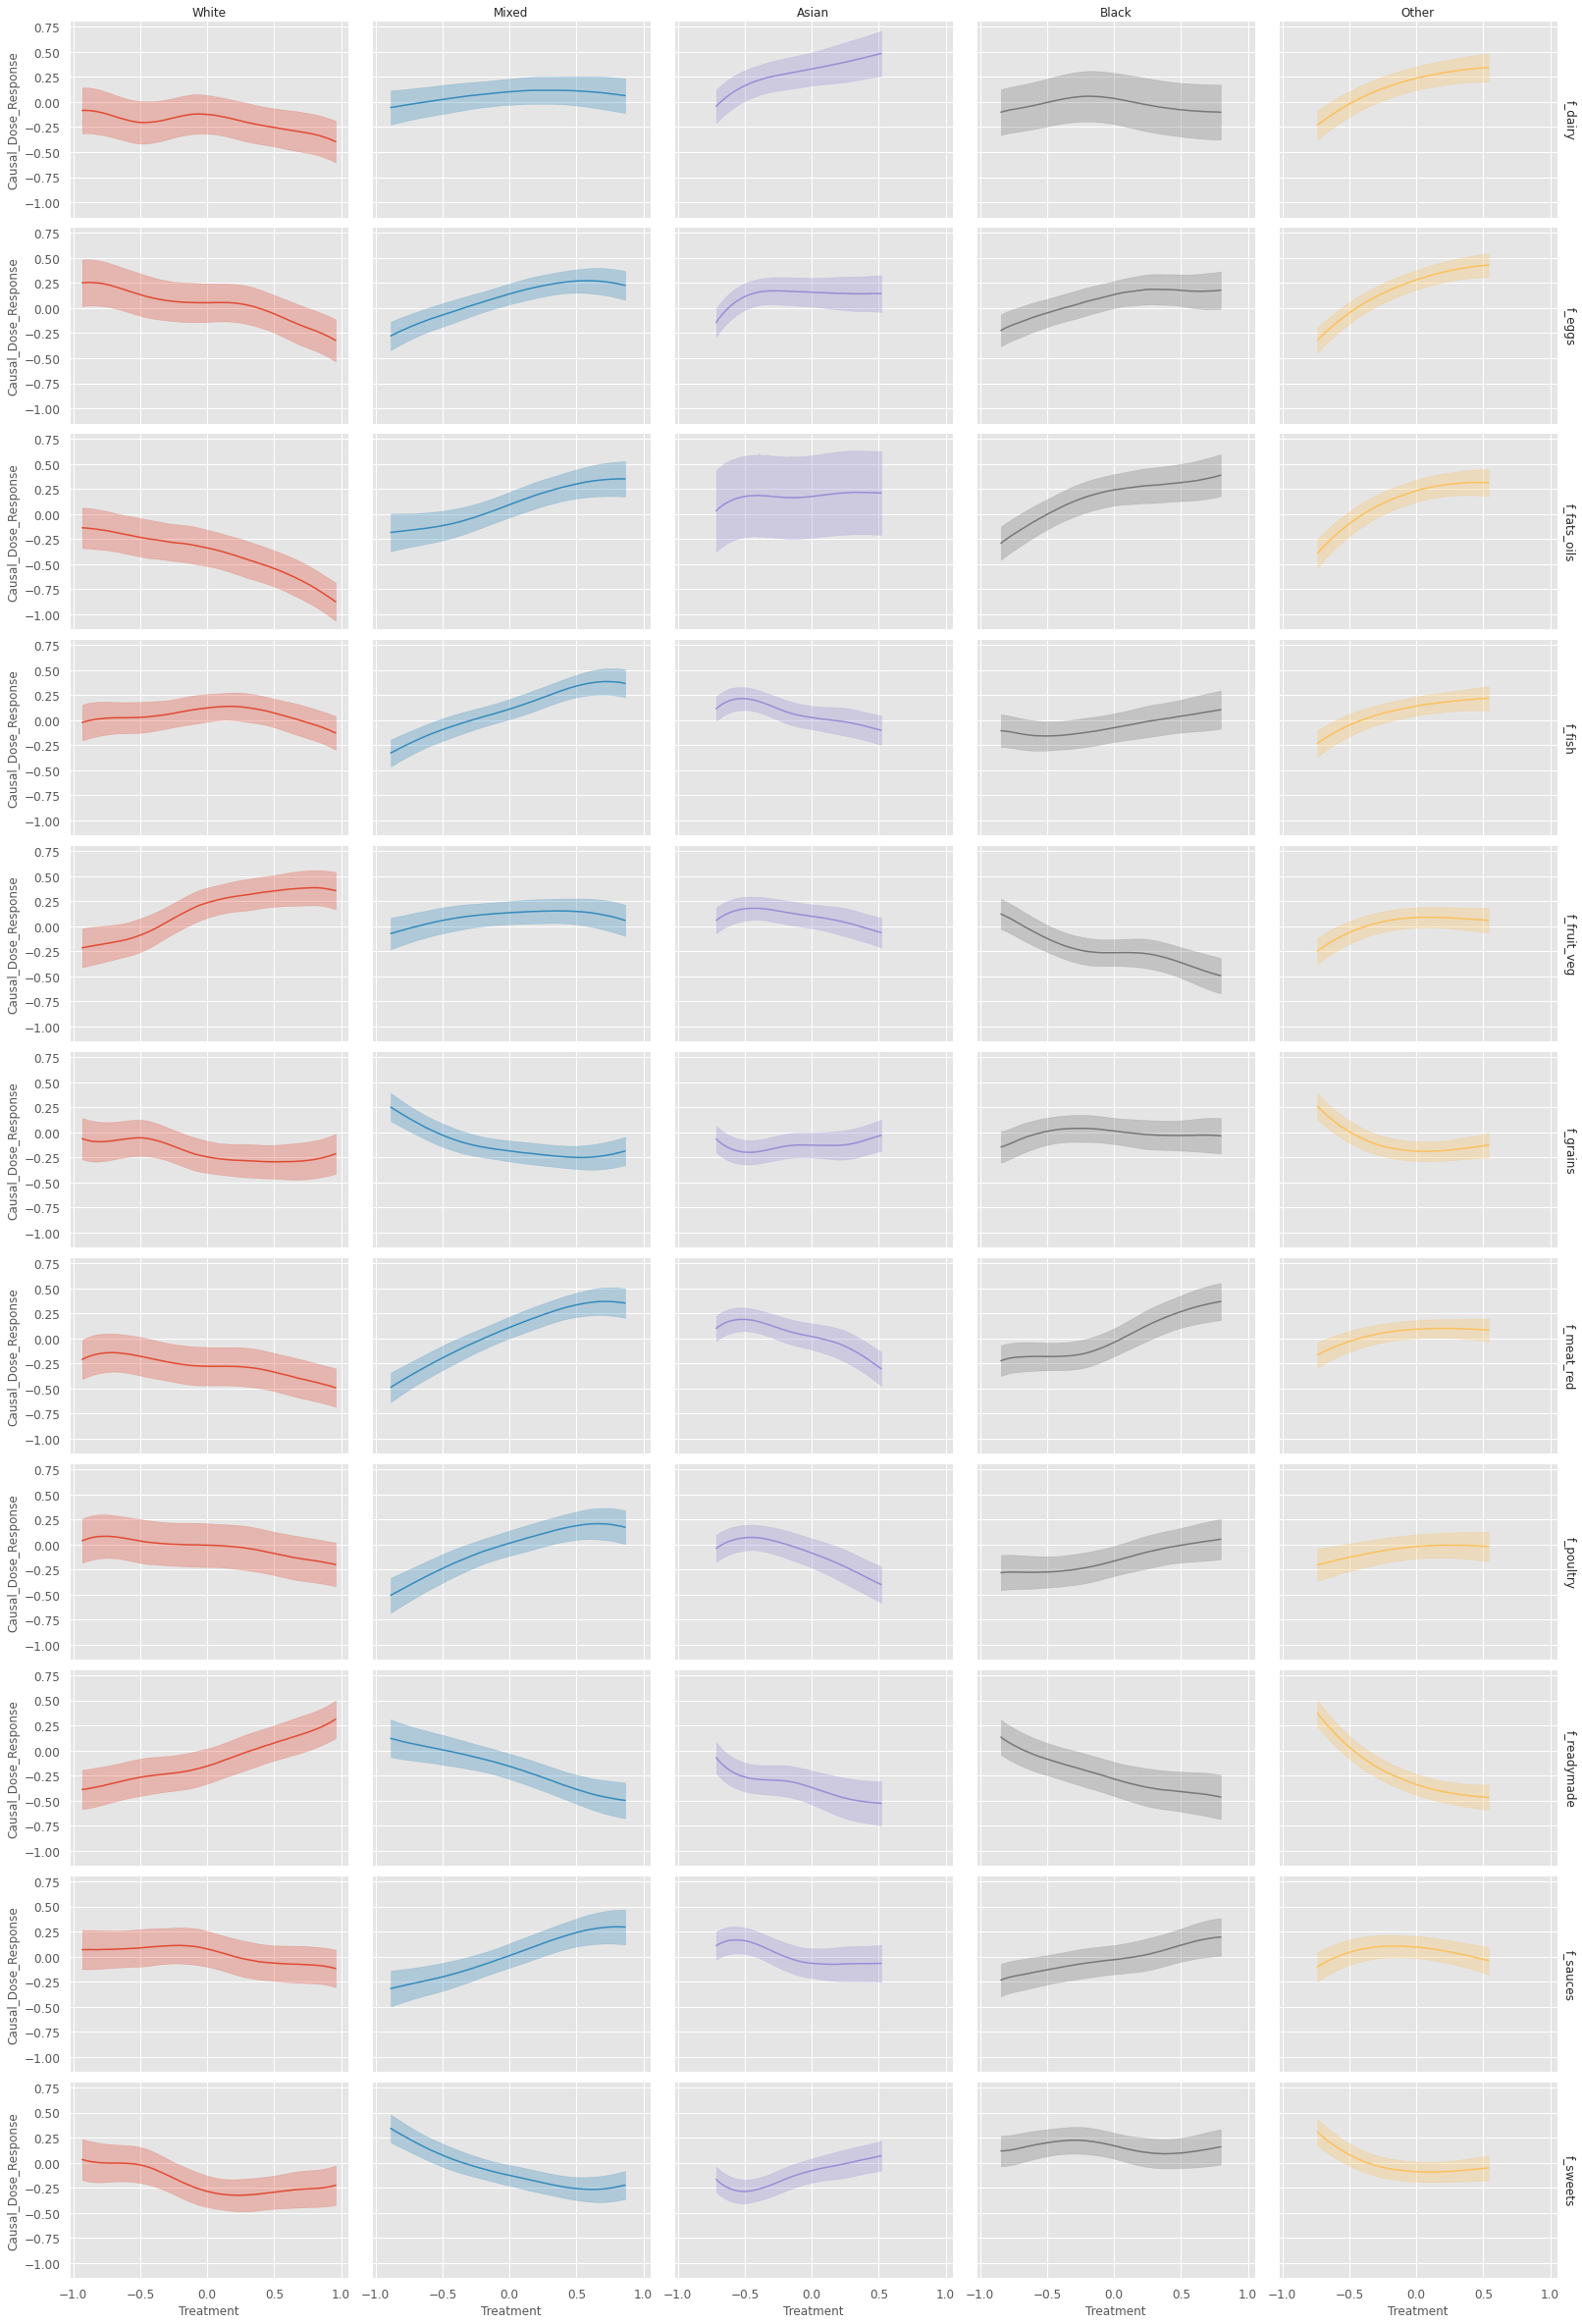

In [77]:
# with sns.plotting_context('paper', font_scale = 1.3):
p = sns.FacetGrid(caus_curve_food_df,
                  row='outcome',
                  col='treatment',
                  hue='is_causal',
                  aspect=1.5,
                  margin_titles=True)
p.map(plt.fill_between, 'Treatment', 'Lower_CI', 'Upper_CI', alpha=.3)
p.map(plt.plot, 'Treatment', 'Causal_Dose_Response')
[plt.setp(ax.texts, text="") for ax in p.axes.flat] # remove the original texts
                                                    # important to add this before setting titles
p.set_titles(row_template = '{row_name}', col_template = '{col_name}')

# NEW ERIC

Each column represents an ethnicity (shown on top of the figure) and each row a food category (shown on the right of the figure). We can observe that .....

# NEW ERIC

Let us now do the same thing with the drink categories.

In [78]:
res_drink_df = pd.DataFrame(columns=['out', 'treat', 'metric'])
caus_curve_drink_df = pd.DataFrame(columns=['Treatment', 'Causal_Dose_Response', 
                                            'Lower_CI', 'Upper_CI', 'outcome', 'treatment'])

for outcome in drink_features:
    print(outcome)
    for i, treat in enumerate(ethnic_features):
        corr_features_df, std_corr_features_df =  compute_corr_df(filtered_df, treat, outcome)
        gps_res, treat_eff_metric = compute_GPS(corr_features_df, std_corr_features_df, treat, outcome)
        res_drink_df = res_drink_df.append({'out': outcome, 'treat': ethnic_feat_short[i], 
                                            'metric': treat_eff_metric}, ignore_index=True)  
        gps_res['outcome'] = np.repeat(outcome, 100)
        gps_res['treatment'] = np.repeat(ethnic_feat_short[i], 100)
        is_causal = (treat_eff_metric > 0)
        gps_res['is_causal'] = np.repeat(is_causal, 100)
        caus_curve_drink_df = caus_curve_drink_df.append(gps_res, ignore_index=True)
         

f_beer
f_soft_drinks
f_spirits
f_tea_coffee
f_water
f_wine


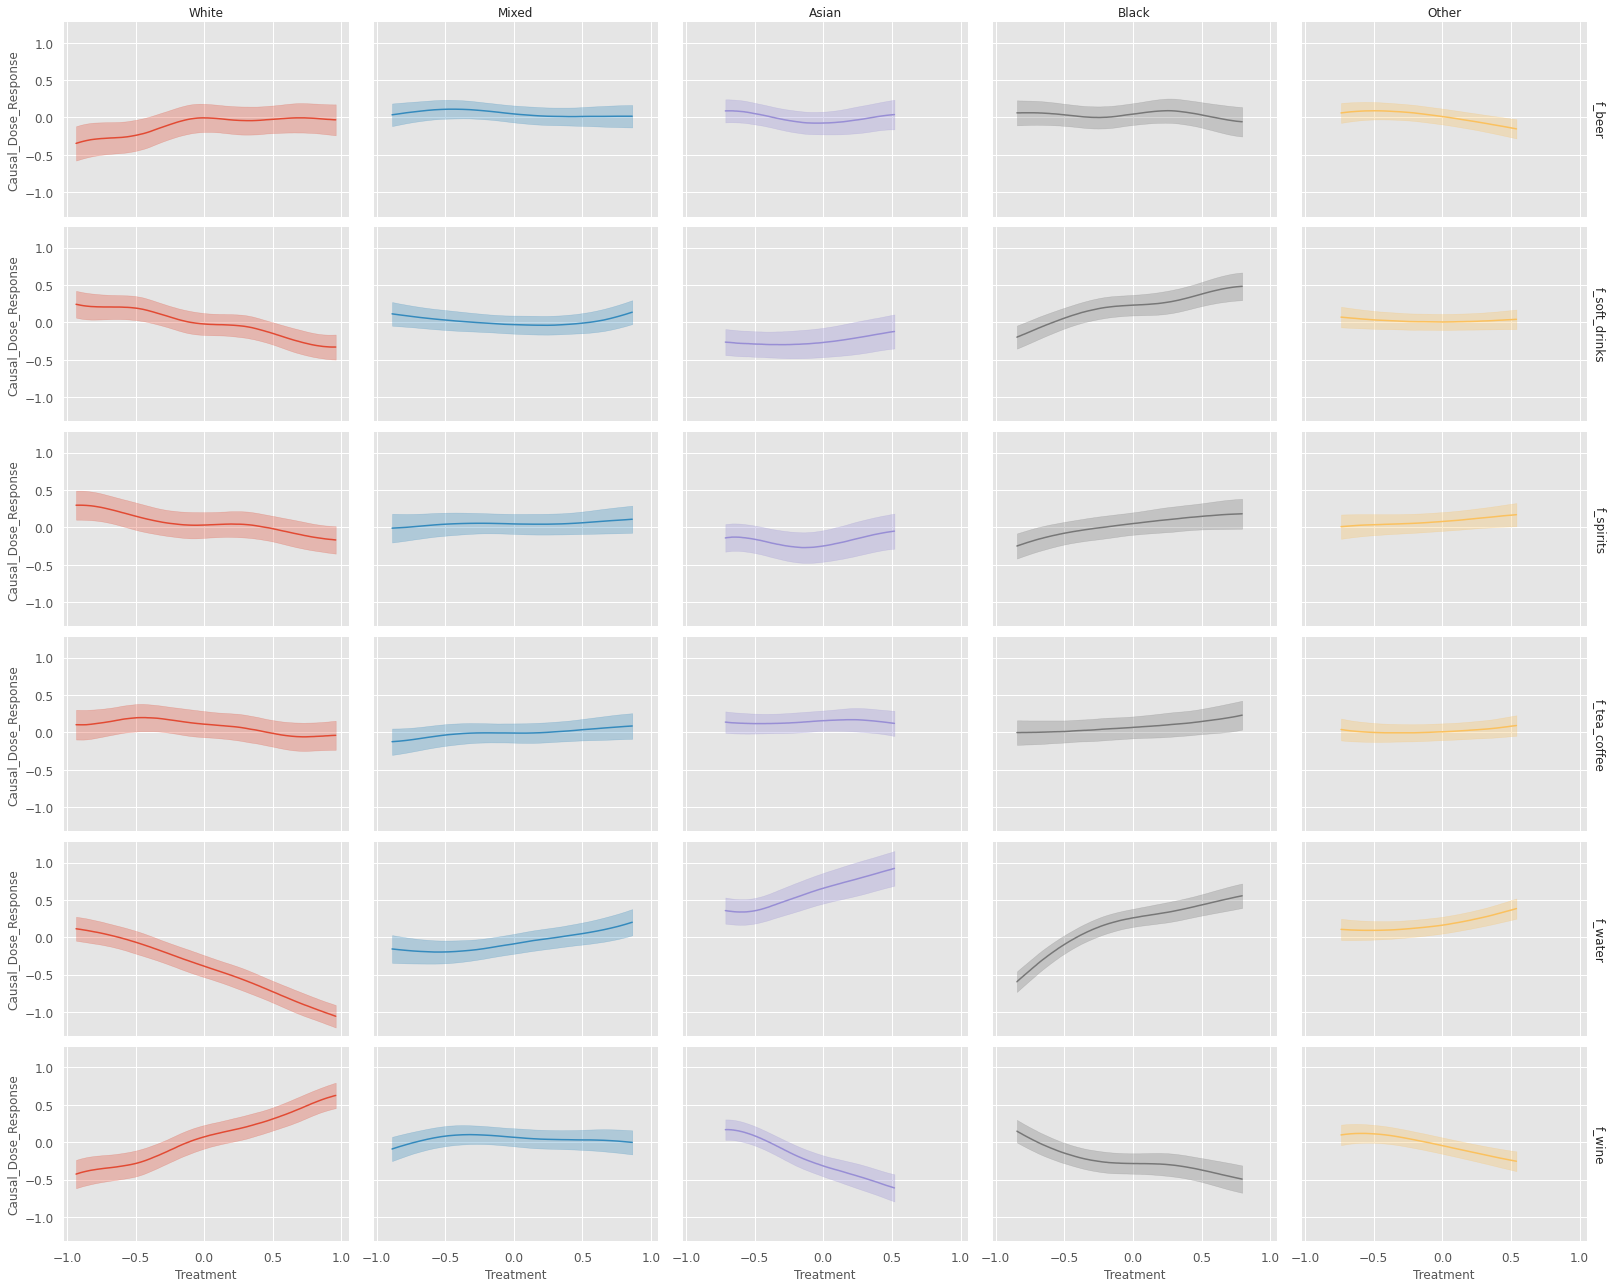

In [79]:
# with sns.plotting_context('paper', font_scale = 1.3):
p = sns.FacetGrid(caus_curve_drink_df,
                  row='outcome',
                  col='treatment',
                  hue='is_causal',
                  aspect=1.5,
                  margin_titles=True)
p.map(plt.fill_between, 'Treatment', 'Lower_CI', 'Upper_CI', alpha=.3)
p.map(plt.plot, 'Treatment', 'Causal_Dose_Response')
[plt.setp(ax.texts, text="") for ax in p.axes.flat] # remove the original texts
                                                    # important to add this before setting titles
p.set_titles(row_template = '{row_name}', col_template = '{col_name}')

# NEW ERIC

Each column represents an ethnicity (shown on top of the figure) and each row a drink category (shown on the right of the figure). We can observe that .....

# NEW ERIC

## Interpretations of the results on causality

# NEW ERIC

## 4. Conclusions

## Visualizations for Data Story

#### Correlation bar plot

In [ ]:
item_corr = np.concatenate((R_food_np, R_drink_np), axis=1)

ethnicities=['White', 'Mix. Eth.', 'Asian', 'Black', 'Oth. Eth. gr.']
food_it = ['Dairy', 'Eggs', 'Fats Oils', 'Fish', 'Fruit Veg.', 'Grains', 'Red Meat', 
           'Poultry', 'Ready made', 'Sauces', 'Sweets', 'Beer', 'Soft Drinks', 'Spirits',
           'Tea & Coffee', 'Water', 'Wine']

data = []

for i, eth in enumerate(ethnicities):
    colors = ['darkcyan' if val > 0 else 'crimson' for val in item_corr[i,:]]
    data.append(go.Bar(x=food_it, y=item_corr[i,:], name=eth, marker_color=colors,
                       visible=False))               

data[0]['visible'] = True

In [ ]:
layout = go.Layout(yaxis_title="Spearman Rank Correlation",
                   xaxis_title="Tesco items",
                   title={'text': "Correlation between Ethnicity and Tesco items",
                          'y':0.9,
                          'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'}
                  )

layout.update(updatemenus=list([
        dict(
            x=0.1,
            y=1.2,
            type = 'dropdown',
            visible = True,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True, False, False, False, False]],
                    label='White',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, True, False, False, False]],
                    label='Mix. Eth.',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, True, False, False]],
                    label='Asian',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, True, False]],
                    label='Black',
                    method='restyle'
                )
                ,
                dict(
                    args=['visible', [False, False, False, False, True]],
                    label='Other Eth. gr.',
                    method='restyle'
                )
            ]),
        )]))
fig=go.Figure(data=data, layout =layout)
fig = fig.add_shape(type="line",
                    x0=10.5, y0=-0.7, x1=10.5, y1=0.7,
                    line=dict(color="lightslategrey",width=1)
                    )
fig = fig.add_shape(type="line",
                    x0=-0.5, y0=-0, x1=16.5, y1=0,
                    line=dict(color="lightslategrey",width=1.5)
                    )

fig.show()

In [ ]:
item_corr = np.concatenate((R_food_np, R_drink_np), axis=1).T

data = []

for i, food in enumerate(food_it):
    colors = ['darkcyan' if val > 0 else 'crimson' for val in item_corr[i,:]]
    data.append(go.Bar(x=ethnicities, y=item_corr[i,:], name=food, marker_color=colors,
                       visible=False))               

data[0]['visible'] = True

In [ ]:
layout = go.Layout(yaxis_title="Spearman Rank Correlation",
                   xaxis_title="Ethnicities",
                   title={'text': "Correlation between Ethnicity and Tesco items",
                          'y':0.9,
                          'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'}
                  )

layout.update(updatemenus=list([
        dict(
            x=0.1,
            y=1.2,
            type = 'dropdown',
            visible = True,
            yanchor='top',
            buttons=list([
                dict(args=['visible', [True, False, False, False, False, False, False, False, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Dairy',method='restyle'),
                dict(args=['visible', [False, True, False, False, False, False, False, False, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Eggs',method='restyle'),
                dict(args=['visible', [False, False, True, False, False, False, False, False, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Fats Oils', method='restyle'),
                dict(args=['visible', [False, False, False, True, False, False, False, False, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Fish',method='restyle'),
                dict(args=['visible', [False, False, False, False, True, False, False, False, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Fruit Veg.', method='restyle'),
                dict(args=['visible', [False, False, False, False, False, True, False, False, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Grains',method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, True, False, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Red Meat', method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, True, False, 
                                       False, False, False, False, False, False, False, False]],
                    label='Poultry',method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, True, 
                                       False, False, False, False, False, False, False, False]],
                    label='Ready made', method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       True, False, False, False, False, False, False, False]],
                    label='Sauces',method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       False, True, False, False, False, False, False, False]],
                    label='Sweets', method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       False, False, True, False, False, False, False, False]],
                    label='Beer',method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       False, False, False, True, False, False, False, False]],
                    label='Soft Drinks', method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       False, False, False, False, True, False, False, False]],
                    label='Spirits',method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       False, False, False, False, False, True, False, False]],
                    label='Tea & Coffee', method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       False, False, False, False, False, False, True, False]],
                    label='Water',method='restyle'),
                dict(args=['visible', [False, False, False, False, False, False, False, False, False, 
                                       False, False, False, False, False, False, False, True]],
                    label='Wine', method='restyle')
            ])
        )]))
fig=go.Figure(data=data, layout =layout)
fig = fig.add_shape(type="line",
                    x0=0.5, y0=-0.7, x1=0.5, y1=0.7,
                    line=dict(color="lightslategrey",width=0)
                    )
fig.show()

#### Map plots

In [ ]:
def append_value(dict_obj, key, value):
    # Check if key exist in dict or not
    if key in dict_obj:
        # Key exist in dict.
        # Check if type of value of key is list or not
        if not isinstance(dict_obj[key], list):
            # If type is not list then make it list
            dict_obj[key] = [dict_obj[key]]
        # Append the value in list
        dict_obj[key].append(value)
    else:
        # As key is not in dict,
        # so, add key-value pair
        dict_obj[key] = value

In [ ]:
import json

In [ ]:
df = full_df

geojson_string = gpd.GeoSeries([df['geometry'][0]]).to_json()
# using json.loads() 
# convert dictionary string to dictionary 
res = json.loads(geojson_string)
res['features'][0]['id'] = df.index[0]

json_dict = res

for i in range(1, df.shape[0]):
    tmp_json_string = gpd.GeoSeries([df['geometry'][i]]).to_json()
    res = json.loads(tmp_json_string)
    res['features'][0]['id'] = df.index[i]
    geo_json = res['features'][0]
    append_value(json_dict, 'features', geo_json)

In [ ]:
features = ['f_fruit_veg', 'f_dairy', 'f_grains', 'f_meat_red', 'f_poultry', 'f_eggs', 'f_fats_oils', 'f_fish',
            'f_readymade', 'f_sauces', 'f_sweets']
data = []

for feat in features:
    data.append(go.Choroplethmapbox(locations = df.index, 
                                    z = df[feat], 
                                    #text = feat, 
                                    colorbar = dict(thickness=20, ticklen=3),
                                    geojson=json_dict,
                                    colorscale = 'magma',
                                    name = feat,
                                    showlegend = True, 
                                    marker_line_width=1, 
                                    marker_opacity=0.9, 
                                    visible=False))
               
data[0]['visible'] = True

layout = go.Layout(height=500,
                   margin={"r":0,"t":0,"l":0,"b":0},
                   mapbox = dict(center= dict(lat=51.49, lon=-0.127),
                                 style="carto-positron", zoom=9))

layout.update(updatemenus=list([
        dict(
            x=0.2,
            y=1,
            #margin={"r":0,"t":0,"l":0,"b":0},
            #borderwidth = 0,
            type = 'dropdown',
            visible = True,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True, False, False, False, False, False, False, False, False, False, False]],
                    label='Fruit Vegetables',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, True, False, False, False, False, False, False, False, False, False]],
                    label='Dairy',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, True, False, False, False, False, False, False, False, False]],
                    label='Grains',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, True, False, False, False, False, False, False, False]],
                    label='Red Meat',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, True, False, False, False, False, False, False]],
                    label='Poultry',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, True, False, False, False, False, False]],
                    label='Eggs',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, False, True, False, False, False, False]],
                    label='Fats Oil',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, False, False, True, False, False, False]],
                    label='Fish',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, False, False, False, True, False, False]],
                    label='Ready Made',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, False, False, False, False, True, False]],
                    label='Sauces',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, False, False, False, False, False, True]],
                    label='Sweets',
                    method='restyle'
                )
            ]),
        )]))
fig=go.Figure(data=data, layout =layout)
#fig.show()

In [ ]:
features = ['f_wine', 'f_soft_drinks', 'f_spirits', 'f_tea_coffee', 'f_water', 'f_beer']
data = []

for feat in features:
    data.append(go.Choroplethmapbox(locations = df.index, 
                                    z = df[feat], 
                                    #text = feat, 
                                    colorbar = dict(thickness=20, ticklen=3),
                                    geojson=json_dict,
                                    colorscale = 'magma',
                                    name = feat,
                                    showlegend = True, 
                                    marker_line_width=1, 
                                    marker_opacity=0.9, 
                                    visible=False))
               
data[0]['visible'] = True

layout = go.Layout(height=500,
                   margin={"r":0,"t":0,"l":0,"b":0},
                   mapbox = dict(center= dict(lat=51.49, lon=-0.127),
                                 style="carto-positron", zoom=9))

layout.update(updatemenus=list([
        dict(
            x=0.2,
            y=1,
            #margin={"r":0,"t":0,"l":0,"b":0},
            #borderwidth = 0,
            type = 'dropdown',
            visible = True,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True, False, False, False, False, False]],
                    label='Wine',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, True, False, False, False, False]],
                    label='Soft Drinks',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, True, False, False, False]],
                    label='Spirits',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, True, False, False]],
                    label='Tea & Coffee',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, True, False]],
                    label='Water',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, False, True]],
                    label='Beer',
                    method='restyle'
                )
            ]),
        )]))
fig=go.Figure(data=data, layout =layout)
#fig.show()

In [ ]:
feats = ['Ethnic_Group;White_(ratio);2011',
         'Ethnic_Group;Mixed/multiple_ethnic_groups_(ratio);2011',
         'Ethnic_Group;Asian/Asian_British_(ratio);2011',
         'Ethnic_Group;Black/African/Caribbean/Black_British_(ratio);2011',
         'Ethnic_Group;Other_ethnic_group_(ratio);2011']

eth_df = df[feats]
eth_df.columns = ['White(%)', 'Mixed Eth.(%)', 'Asian(%)', 'Black(%)', 'Oth. Eth. Gr.(%)']

features = eth_df.columns
data = []

for feat in features:
    data.append(go.Choroplethmapbox(locations = df.index, 
                                    z = eth_df[feat], 
                                    #text = feat, 
                                    colorbar = dict(thickness=20, ticklen=3),
                                    geojson=json_dict,
                                    colorscale = 'magma',
                                    name = feat,
                                    showlegend = True, 
                                    marker_line_width=1, 
                                    marker_opacity=0.9, 
                                    visible=False))
               
data[0]['visible'] = True

layout = go.Layout(height=500,
                   margin={"r":0,"t":0,"l":0,"b":0},
                   mapbox = dict(center= dict(lat=51.49, lon=-0.127),
                                 style="carto-positron", zoom=9))

layout.update(updatemenus=list([
        dict(
            x=0.2,
            y=1,
            #margin={"r":0,"t":0,"l":0,"b":0},
            #borderwidth = 0,
            type = 'dropdown',
            visible = True,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True, False, False, False, False]],
                    label='White',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, True, False, False, False]],
                    label='Mixed Eth.',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, True, False, False]],
                    label='Asian',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, True, False]],
                    label='Black',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, False, False, True]],
                    label='Other Eth. Gr.',
                    method='restyle'
                )
            ]),
        )]))
fig=go.Figure(data=data, layout =layout)
#fig.show()

#### Paircat plot

In [ ]:
employ = full_df['Economic_Activity;Employment_ratio;2011']
salary = full_df['Household_Income,_2011/12;Median_Annual_Household_Income_estimate_(£)']
items_entropy = full_df['h_items_norm']
avg_age = full_df['avg_age']
h_ethnicity = full_df['Ethnic_Group;h_ethnicities_norm;2011']

In [ ]:
# Create dimensions
rich_cat_feat = pd.cut(salary, bins=np.quantile(salary, [0, 0.1, 0.25, 0.75, 0.9, 1]), labels=[0,1,2,3,4],
                       include_lowest=True)

rich_dim = go.parcats.Dimension(values=rich_cat_feat, label="Richness of the area",
                                categoryarray=[0, 1, 2, 3, 4], 
                                ticktext=["very poor", "poor", "medium", "rich", "very rich"])

employ_cat_feat = pd.cut(employ, bins=[0, 50, 60, 70, 80, 100], labels=[0,1,2,3,4],
                         include_lowest=True)

employ_dim = go.parcats.Dimension(values=employ_cat_feat, label="Employment rate",
                                  categoryarray=[0, 1, 2, 3, 4], 
                                  ticktext=['0 to 50%', '50 to 60%', '60 to 70%', '70 to 80%', '80 to 100%'])

age_cat_feat = pd.cut(avg_age, bins=[25, 30, 35, 40, 45, 60], labels=[0,1,2,3,4],
                      include_lowest=True)

age_dim = go.parcats.Dimension(values=age_cat_feat, label="Avg. Age of the area",
                               categoryarray=[0, 1, 2, 3, 4], 
                               ticktext=['25 to 30', '30 to 35', '35 to 40', '40 to 45', '45 to 60'])

hitems_cat_feat = pd.cut(items_entropy, bins=np.quantile(items_entropy, [0, 0.1, 0.25, 0.75, 0.9, 1]),
                         labels=["very similar", "similar", 'medium', "diverse", "very diverse"], 
                         include_lowest=True)

hitems_dim = go.parcats.Dimension(values=hitems_cat_feat, label="Food Purchase Diversity of the area")

h_ethnicity_cat_feat = pd.cut(h_ethnicity, bins=np.quantile(h_ethnicity, [0, 0.1, 0.25, 0.75, 0.9, 1]),
                                  labels=["very similar", "similar", "medium", "diverse", "very diverse"],
                                  include_lowest=True)

h_ethnicity_dim = go.parcats.Dimension(values=h_ethnicity_cat_feat, label="Ethnicity Diversity of the area")


# Create parcats trace
#color = df_cat.Ethnicity_entropy;
color = rich_cat_feat;
color2 = employ_cat_feat;
color3 = age_cat_feat;
colorscale = px.colors.sequential.Inferno;
#[[0, 'aliceblue'], [1, 'limegreen']];

data = [go.Parcats(dimensions=[hitems_dim, rich_dim, h_ethnicity_dim],
                                   line={'color': color, 'colorscale': colorscale},
                                   hoveron='color', hoverinfo='count+probability',
                                   labelfont={'size': 14, 'family': 'Times'},
                                   tickfont={'size': 12, 'family': 'Times'},
                                   arrangement='freeform', visible=True),
        go.Parcats(dimensions=[hitems_dim, employ_dim, h_ethnicity_dim],
                   line={'color': color2, 'colorscale': colorscale},
                   hoveron='color', hoverinfo='count+probability',
                   labelfont={'size': 14, 'family': 'Times'},
                   tickfont={'size': 12, 'family': 'Times'},
                   arrangement='freeform', visible=False),
        go.Parcats(dimensions=[hitems_dim, age_dim, h_ethnicity_dim],
                   line={'color': color3, 'colorscale': colorscale},
                   hoveron='color', hoverinfo='count+probability',
                   labelfont={'size': 14, 'family': 'Times'},
                   tickfont={'size': 12, 'family': 'Times'},
                   arrangement='freeform', visible=False)
       ]

layout = go.Layout()

layout.update(updatemenus=list([
        dict(
            x=0.1,
            y=1.2,
            type = 'dropdown',
            visible = True,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True, False, False]],
                    label='Richness',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, True, False]],
                    label='Employment Rate',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False, False, True]],
                    label='Avg. Age',
                    method='restyle'
                )
            ]),
        )]))
fig=go.Figure(data=data, layout =layout)

fig.show()

#### Linear regression plot

In [ ]:
pred_list = []
r2_list = []

#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df['h_ethnicity'],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df['employment_rate'],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df['avg_age'],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df['median_household_income'],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df[['h_ethnicity', 'employment_rate']],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df[['h_ethnicity', 'avg_age']],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df[['h_ethnicity', 'median_household_income']],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df[['h_ethnicity', 'avg_age', 
                                                                'median_household_income', 'employment_rate']],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)
#########
X_train, X_test, y_train, y_test = train_test_split(lin_reg_df[['avg_age','median_household_income', 'employment_rate']],
                                                    lin_reg_df['h_items'], test_size=0.3, random_state=42)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

olsres = sm.OLS(y_train, X_train).fit()
pred_list.append(olsres.predict(X_test))
r2_list.append(olsres.rsquared)

In [ ]:
from plotly.offline import init_notebook_mode, iplot, plot
from plotly import tools
from plotly.subplots import make_subplots

In [ ]:
### Create individual figures
# START
fig = tools.make_subplots(rows=1, cols=2, column_widths=[0.7, 0.3], 
                          subplot_titles=('Regression prediction',  'Variance Explained'))

trace1 = go.Scatter(x = y_test, y = pred_list[0], mode = 'markers', showlegend=False, visible=True, marker=dict(size=3))
trace2 = go.Scatter(x = y_test, y = pred_list[1], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))
trace3 = go.Scatter(x = y_test, y = pred_list[2], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))
trace4 = go.Scatter(x = y_test, y = pred_list[3], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))
trace5 = go.Scatter(x = y_test, y = pred_list[4], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))
trace6 = go.Scatter(x = y_test, y = pred_list[5], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))
trace7 = go.Scatter(x = y_test, y = pred_list[6], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))
trace8 = go.Scatter(x = y_test, y = pred_list[7], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))
trace9 = go.Scatter(x = y_test, y = pred_list[8], mode = 'markers', showlegend=False, visible=False, marker=dict(size=3))

fig.append_trace(trace1, 1, 1)
fig.update_layout(yaxis_range=[-6,3], xaxis_range=[-6,3])
fig.append_trace(trace2, 1, 1)
fig.append_trace(trace3, 1, 1)
fig.append_trace(trace4, 1, 1)
fig.append_trace(trace5, 1, 1)
fig.append_trace(trace6, 1, 1)
fig.append_trace(trace7, 1, 1)
fig.append_trace(trace8, 1, 1)
fig.append_trace(trace9, 1, 1)

trace11 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[0]],
                width=0.2, showlegend=False, visible=True)
trace12 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[1]],
                width=0.2, showlegend=False, visible=False)
trace13 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[2]],
                width=0.2, showlegend=False, visible=False)
trace14 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[3]],
                width=0.2, showlegend=False, visible=False)
trace15 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[4]],
                width=0.2, showlegend=False, visible=False)
trace16 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[5]],
                width=0.2, showlegend=False, visible=False)
trace17 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[6]],
                width=0.2, showlegend=False, visible=False)
trace18 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[7]],
                width=0.2, showlegend=False, visible=False)
trace19 = go.Bar(x=['R2 diversity ethnicity', 'R2 Model'], y=[r2_list[0],r2_list[8]],
                width=0.2, showlegend=False, visible=False)

fig.append_trace(trace11, 1, 2)
fig.append_trace(trace12, 1, 2)
fig.append_trace(trace13, 1, 2)
fig.append_trace(trace14, 1, 2)
fig.append_trace(trace15, 1, 2)
fig.append_trace(trace16, 1, 2)
fig.append_trace(trace17, 1, 2)
fig.append_trace(trace18, 1, 2)
fig.append_trace(trace19, 1, 2)
# END

### Create buttons for drop down menu
labels=['Div. Eth.', 'Employ. Rate', 'Avg. Age', 'Med. Income', 'Eth. + Employ.', 'Eth. + Age', 'Eth. + Income',
        'Eth. + Employ. + Age + Inc.', 'Employ. + Age + Inc.']
buttons = []
for i, label in enumerate(labels):
    visibility = [i==j for j in range(len(labels))]
    button = dict(
                 label =  label,
                 method = 'update',
                 args = [{'visible': visibility},
                     #{'title': label}
                        ])
    buttons.append(button)

updatemenus = list([
    dict(active=0,
         x=0.1,
         y=1.2,
         buttons=buttons
    )
])

fig['layout']['title'] = {'text': "Regression Analysis",
                          'y':0.95,
                          'x':0.5,
                          'xanchor': 'center',
                          'yanchor': 'top'}
fig['layout']['showlegend'] = True
fig['layout']['updatemenus'] = updatemenus
# edit axis labels
fig['layout']['xaxis']['title']='True items diversity'
fig['layout']['yaxis']['title']='Predicted items diversity'
#fig['layout']['yaxis2']['title']='Variance Explained'
fig['layout']['yaxis2']['range']=[0,0.2]

iplot(fig, filename='dropdown')

In [ ]:
col_causal = ['aliceblue' if met < 0 else 'lightpink' for met in caus_metric]

fig = go.Figure(data=[go.Table(
    columnwidth = [400,80,80],
    header=dict(values=list(sort_df.columns[0:5]),
                #fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[sort_df.feature, sort_df.correlation, 
                       sort_df.caus_metric, sort_df.corr_rank, sort_df.caus_rank],
               line_color=[col_causal], fill_color=[col_causal],
               #fill_color='lavender',
               align='left'))
])

fig.show()